# WEBB Traders: Index Futures Pair Trading Research 
### Nicolas Buchwalder Feb '24

# 0. Imports

## 0.1 Module imports + seed setting

In [1]:
from collections import deque
from abc import ABC, abstractmethod
from enum import Enum
from typing import NamedTuple, List, Tuple, Dict, Optional

from itertools import chain, count, cycle

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

from hurst import compute_Hc

import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.ticker import FixedLocator
from matplotlib.lines import Line2D

import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme()

In [2]:
# setting seed for reproducability (if randomness involved)
np.random.seed(42)

## 0.2 Data Import

In [3]:
# importing data
raw_df = pd.read_csv(
    "ESNQ.csv",
    index_col=["symbol", "year", "month", "day", "hour", "minute", "second"]    # adding directly the index columns
).sort_index()

In [4]:
raw_df

bid_price  bid_size  ask_price  \
symbol year month day hour minute second                                   
ESc1   2022 1     3   14   0      0         4775.00        27    4775.25   
                                  1         4775.00        15    4775.25   
                                  2         4774.50        25    4774.75   
                                  3         4774.75        25    4775.00   
                                  4         4774.50        19    4774.75   
...                                             ...       ...        ...   
NQc1   2022 1     31  20   59     55       14906.50         2   14907.25   
                                  56       14907.00         2   14907.50   
                                  57       14904.25         2   14904.50   
                                  58       14902.00         2   14903.00   
                                  59       14895.25         2   14896.50   

                                          ask_size  mid_price  
symbol year month day hour minute second                       
ESc1   2022 1     3   14   0      0             21   4775.125  
                                  1             53   4775.125  
                                  2             34   4774.625  
                                  3             21   4774.875  
                                  4             38   4774.625  
...                                            ...        ...  
NQc1   2022 1     31  20   59     55             2  14906.875  
                                  56             3  14907.250  
                                  57             1  14904.375  
                                  58             3  14902.500  
                                  59             3  14895.875  

[1044000 rows x 5 columns]

# 1. Checking quality of dataset

## 1.1 Checking dtypes

In [5]:
# checking validity of index dtypes  
raw_df.index.dtypes

symbol    object
year       int64
month      int64
day        int64
hour       int64
minute     int64
second     int64
dtype: object

In [6]:
# checking validity of columns dtypes
raw_df.dtypes

bid_price    float64
bid_size       int64
ask_price    float64
ask_size       int64
mid_price    float64
dtype: object

## 1.2 Checking NaNs

In [7]:
# checking if NaNs exist in index
raw_df.index.to_frame().isna().any()

symbol    False
year      False
month     False
day       False
hour      False
minute    False
second    False
dtype: bool

In [8]:
# checking if NaNs exist in columns
raw_df.isna().any()

bid_price    False
bid_size     False
ask_price    False
ask_size     False
mid_price    False
dtype: bool

## 1.3 Checking index validity

In [9]:
# checking for duplicates in the index
raw_df.index.is_unique

True

In [10]:
# checking that only two time symbols exist
raw_df.index.get_level_values("symbol").unique()

Index(['ESc1', 'NQc1'], dtype='object', name='symbol')

In [11]:
# checking the number of years in dataset
raw_df.index.get_level_values("year").unique()

Index([2022], dtype='int64', name='year')

In [12]:
# checking the number of months in dataset
raw_df.index.get_level_values("month").unique()

Index([1], dtype='int64', name='month')

In [13]:
# checking that days are valid
raw_df.index.get_level_values("day").unique()

Index([3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 24, 25, 26, 27,
       28, 31],
      dtype='int64', name='day')

In [14]:
# checking that hours are valid
raw_df.index.get_level_values("hour").unique()

Index([14, 15, 16, 17, 18, 19, 20], dtype='int64', name='hour')

In [15]:
# checking that minutes are valid
raw_df.index.get_level_values("minute").unique()

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59],
      dtype='int64', name='minute')

In [16]:
# checking that seconds are valid
raw_df.index.get_level_values("second").unique()

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59],
      dtype='int64', name='second')

In [17]:
# checking that the timestamps for both symbols are exactly the same
(raw_df.loc[pd.IndexSlice["NQc1"], :].index == raw_df.loc[pd.IndexSlice["ESc1"], :].index).all()

True

In [18]:
# checking that all periods within days are contiguous (no missing minute or second in between)
# grouping data by day (for both symbols as they have the same index)
days = raw_df.unstack("symbol").sort_index().groupby(level=["year", "month", "day"])
contiguous = {}
# iterating over each daily data
for day, data in days:
    # getting datetimeindex of day's data
    day_idx = pd.to_datetime(data.index.to_frame(index=False)).rename("datetime").to_frame().set_index("datetime")
    # check that resampled index (each second between start and end of daily data), is the same as the actual index
    try:
        contiguous[day] = (day_idx.index == day_idx.groupby(pd.Grouper(freq="1s")).size().index).all()
    except:
        contiguous[day] = False
# checking that they are all contiguous
pd.Series(contiguous).all()

True

In [19]:
# checking that data is of same size each day
raw_df.loc[pd.IndexSlice["NQc1", 2022, 1], :].groupby(level="day").size()

day
3     25200
4     25200
5     25200
6     25200
7     25200
10    25200
11    25200
12    25200
13    25200
14    25200
17    18000
18    25200
19    25200
20    25200
21    25200
24    25200
25    25200
26    25200
27    25200
28    25200
31    25200
dtype: int64

In [20]:
# 17th is smaller: checking data on that day: missing from 19:00 to 20:59:59
raw_df.loc[pd.IndexSlice["NQc1", 2022, 1, 17], :]

bid_price  bid_size  ask_price  ask_size  mid_price
hour minute second                                                     
14   0      0        15608.75         1    15609.5         1  15609.125
            1        15608.50         3    15609.5         3  15609.000
            2        15608.50         3    15609.5         3  15609.000
            3        15609.75         3    15610.5         1  15610.125
            4        15609.00         4    15610.0         2  15609.500
...                       ...       ...        ...       ...        ...
18   59     55       15557.75         2    15560.0         5  15558.875
            56       15557.75         2    15560.0         5  15558.875
            57       15557.75         2    15560.0         5  15558.875
            58       15557.75         2    15560.0         5  15558.875
            59       15557.75         2    15560.0         5  15558.875

[18000 rows x 5 columns]

## 1.4 Checking columns validity

In [21]:
# checking that no nonpositive values exist (cannot have negative sizes or prices)
raw_df[(raw_df<=0).any(axis=1)]

Empty DataFrame
Columns: [bid_price, bid_size, ask_price, ask_size, mid_price]
Index: []

In [22]:
# checking that mid price is indeed bid + ask / 2
(((raw_df["bid_price"] + raw_df["ask_price"]) / 2) == raw_df["mid_price"]).all()

True

In [23]:
# checking that there is no unexpected enormous price changes
raw_df[["bid_price", "ask_price", "mid_price"]].groupby("symbol").pct_change().describe()

bid_price     ask_price     mid_price
count  1.043998e+06  1.043998e+06  1.043998e+06
mean  -1.414542e-07 -1.414314e-07 -1.414835e-07
std    1.116696e-04  1.116502e-04  1.112950e-04
min   -2.051123e-02 -2.054393e-02 -2.052758e-02
25%   -4.904365e-05 -4.903403e-05 -4.471342e-05
50%    0.000000e+00  0.000000e+00  0.000000e+00
75%    4.809234e-05  4.810545e-05  4.116166e-05
max    2.178176e-02  2.176179e-02  2.177177e-02

# 2. Train Test split

In [24]:
# copying raw dataframe into analysis dataframe
df = raw_df.copy().unstack("symbol")
# setting datetimeindex instead of multiindex of year, month, day, hour, minute, second (easier to manipulate)
df["datetime"] = pd.to_datetime(df.index.to_frame())
df.set_index("datetime", inplace=True)

In [25]:
# getting all dates in dataset
total_dates = df.groupby(df.index.date).size().index
total_dates

Index([2022-01-03, 2022-01-04, 2022-01-05, 2022-01-06, 2022-01-07, 2022-01-10,
       2022-01-11, 2022-01-12, 2022-01-13, 2022-01-14, 2022-01-17, 2022-01-18,
       2022-01-19, 2022-01-20, 2022-01-21, 2022-01-24, 2022-01-25, 2022-01-26,
       2022-01-27, 2022-01-28, 2022-01-31],
      dtype='object')

In [26]:
# setting cutoff date between train and test
last_train_date = "2022-01-24"
# getting train and test proportions
(total_dates<=pd.Timestamp(last_train_date).date()).sum() / len(total_dates), (total_dates>pd.Timestamp(last_train_date).date()).sum() / len(total_dates)

(0.7619047619047619, 0.23809523809523808)

In [27]:
# train test split
train_df = df.loc[:"2022-01-24"].stack("symbol").swaplevel(0, 1).sort_index()
test_df = df.loc["2022-01-25":].stack("symbol").swaplevel(0, 1).sort_index()

In [28]:
# getting dates 
train_dates = train_df.groupby(train_df.index.get_level_values("datetime").date).size().index
test_dates = test_df.groupby(test_df.index.get_level_values("datetime").date).size().index

In [29]:
# checking that proportions match (not exactly as the Jan 17th has less data)
train_df.unstack(0).shape[0] / df.shape[0], test_df.unstack(0).shape[0] / df.shape[0]

(0.7586206896551724, 0.2413793103448276)

# 3. Exploratory Analysis

### 3.0 (SKIP THIS) Helper functions for graphing data without having time gaps outside of trading hours

In [30]:
# THOSE ARE ONLY USED TO MAKE SURE THAT DTYPES OF ARGUMENTS OF GRAPH_CONTINUOUS FUNCTION BELOW ARE GOOD

def check_series_type(series):
    # check if the input is a pd.Series or a list of pd.Series.
    if isinstance(series, pd.Series):
        return True
    if isinstance(series, list) and all(isinstance(s, pd.Series) for s in series):
        return True
    return False

def check_indexes_match(series_list):
    # check if all series in the list have exactly matching indexes.
    if len(series_list) > 1:
        first_index = series_list[0].index
        for series in series_list[1:]:
            if not series.index.equals(first_index):
                return False
    return True

def check_series_validity(primary_series, secondary_series):
    # check for correct types
    if not check_series_type(primary_series):
        raise TypeError(f"primary_series must be a pd.Series or a list of pd.Series")
    if secondary_series is not None and not check_series_type(secondary_series):
        raise TypeError(f"secondary_series must be a pd.Series, a list of pd.Series, or None.")
    
    # flatten the series into a list for easier processing
    primary_series_list = [primary_series] if isinstance(primary_series, pd.Series) else primary_series
    secondary_series_list = [secondary_series] if isinstance(secondary_series, pd.Series) else secondary_series
    
    # fombine the lists if secondary_series is not None
    all_series = primary_series_list + secondary_series_list if secondary_series is not None else primary_series_list
    
    # check for matching indexes
    if not check_indexes_match(all_series):
        raise ValueError("Not all series have matching indexes.")

    return all_series[0].index

In [31]:
def graph_continuous(primary_series, secondary_series=None, kind="line", title=None, labels=None):  
    
    # checking that the series are in good format and return index
    reference_index = check_series_validity(primary_series, secondary_series)
    fig, p_ax = plt.subplots(figsize=(16, 6))
    
    # get unique days to slice by day
    unique_days, unique_indices = np.unique(reference_index.date, return_index=True)
    unique_indices = np.append(unique_indices, len(reference_index))
    # set dates as string for the xticks
    dates_str = [reference_index[i].strftime('%b-%d') for i in unique_indices[:-1]]
    # set xticks as intengers
    int_range = range(len(reference_index))
    # get colors cycle
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  
    color_cycle = cycle(colors)

    # plot series in function of the types
    def plot_type(ax, x, y, color):
        if kind == "line":
            ax.plot(x, y, color=color)
        elif kind == "scatter":
            ax.scatter(x, y, s=2, color=color)
        elif kind == "bar":
            ax.bar(x, y, color=color)
        else:
            raise ValueError("Plot kind must be in ['line', 'scatter', 'bar']")

    # plot one series 
    def plot_series(series, ax, label):
        color = next(color_cycle)
        # plot each day
        for start, end in zip(unique_indices[:-1], unique_indices[1:]):
            plot_type(ax, int_range[start:end], series.values[start:end], color=color)
            
        # set xticks
        ax.tick_params(axis='y', colors=color) 
        ax.yaxis.label.set_color(color)
        if label:
            ax.set_ylabel(label, color=color)
        ax.xaxis.set_major_locator(FixedLocator(unique_indices[:-1]))
        ax.set_xticklabels(dates_str)
        
        return ax

    # plot all series
    for p_series in (primary_series if isinstance(primary_series, list) else [primary_series]):
        p_ax = plot_series(p_series, p_ax, labels[0] if labels else None)

    if title:
        p_ax.set_title(title)
        
    # if there's data to plot on a secondary ax
    if secondary_series is not None:
        sec_ax = p_ax.twinx()
        for s_series in (secondary_series if isinstance(secondary_series, list) else [secondary_series]):
            sec_ax = plot_series(s_series, sec_ax, labels[1] if labels else None)
        sec_ax.grid(False)

        return p_ax, sec_ax
        
    return p_ax

## 3.1 Mid Prices Analysis

In [32]:
mid_prices = train_df["mid_price"].unstack("symbol")

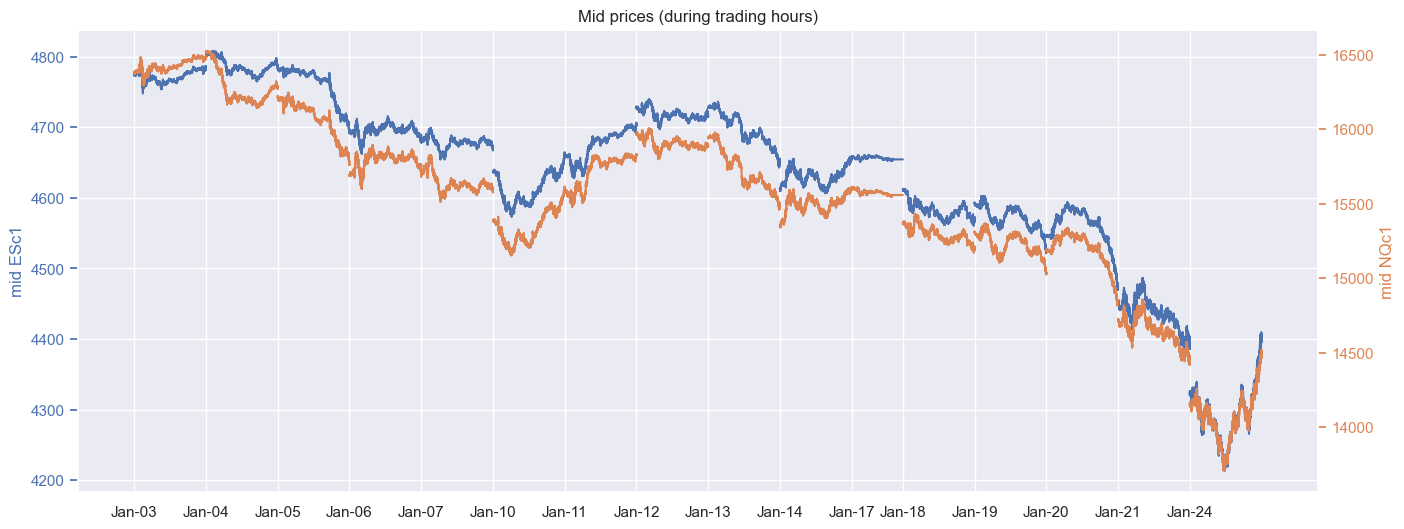

In [33]:
ax = graph_continuous(
    mid_prices["ESc1"], 
    mid_prices["NQc1"], 
    title="Mid prices (during trading hours)", 
    labels=["mid ESc1", "mid NQc1"]
)

In [34]:
# both time series are clearly highly correlated, and maybe cointegrated

/var/folders/9w/vls_pj350g3b62pyz_4t5hp80000gn/T/ipykernel_92597/1312653657.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([str(p.date()) for p in mid_prices[::len(mid_prices)//10].index])


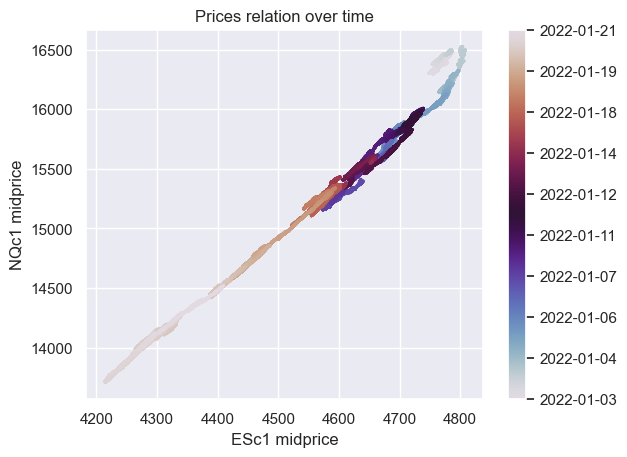

In [35]:
# plotting relationship of both prices
points = plt.scatter(mid_prices["ESc1"], mid_prices["NQc1"], c=np.linspace(0.1, 1, len(mid_prices)), s=1, cmap="twilight")
cbar = plt.colorbar(points)
cbar.ax.set_yticklabels([str(p.date()) for p in mid_prices[::len(mid_prices)//10].index])
plt.xlabel("ESc1 midprice")
plt.ylabel("NQc1 midprice")
_ = plt.title("Prices relation over time")

In [36]:
# checking levels correlation
mid_prices.corr()

symbol      ESc1      NQc1
symbol                    
ESc1    1.000000  0.987651
NQc1    0.987651  1.000000

In [37]:
# checking returns correlation
returns = mid_prices.groupby(pd.Grouper(freq="1D")).pct_change()
returns.corr()

symbol     ESc1     NQc1
symbol                  
ESc1    1.00000  0.88711
NQc1    0.88711  1.00000

Text(0.5, 1.0, 'Distribution of Rolling Correlation for Multiple Scales')

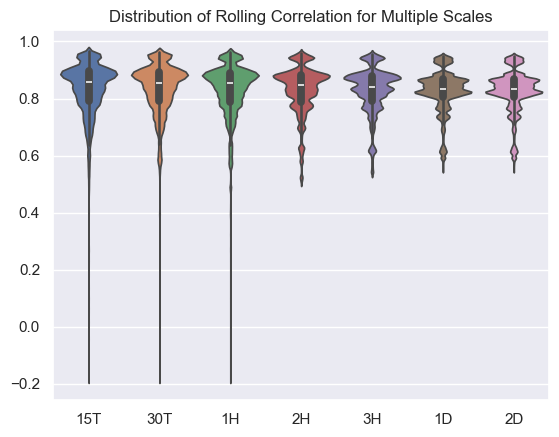

In [38]:
# let's check if this correlation is high on shorter periods
periods = ["15T", "30T", "1H", "2H", "3H", "1D", "2D"]

rolling_corrs = pd.concat([
    returns.groupby(pd.Grouper(freq="1D")).rolling(p, min_periods=15 * 60).corr().droplevel(0).xs("NQc1", level="symbol")["ESc1"]
    for p in periods
], axis=1)
rolling_corrs.columns = periods
    
ax = sns.violinplot(rolling_corrs)
ax.set_title("Distribution of Rolling Correlation for Multiple Scales")

In [39]:
# correlation seems to be highly stable (except a new exceptions, surely due to too few datapoints)

## 3.2 Trading hours vs non trading hours

In [40]:
# looking on the levels graph, there seems to be great jumps outside of trading hours, let's see how they compare with movements inside trading hours

# getting first and last price of each day
first_last_next = train_df["mid_price"].groupby(["symbol", pd.Grouper(level="datetime", freq="1D")]).agg(["first", "last"])
# add price of next day to current day
first_last_next["next"] = first_last_next["first"].groupby("symbol").shift(-1)
first_last_next.columns = ["open", "close", "next_open"]
first_last_next.dropna(inplace=True)
# compute price changes between open to close and close to next open
first_last_next["o2c"] = first_last_next["close"] - first_last_next["open"]
first_last_next["c2o"] = first_last_next["next_open"] - first_last_next["close"]

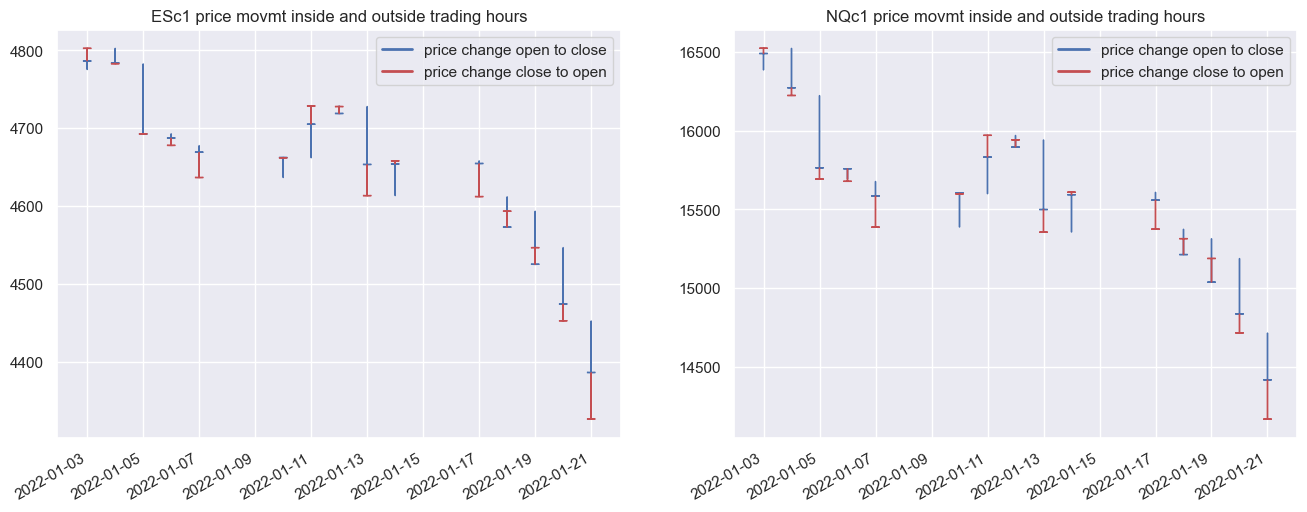

In [41]:
def plot_price_changes(symbol, ax):
    for i, (index, row) in enumerate(first_last_next.loc[symbol].iterrows()):
        x, y, dx, dy = date2num(index), row['open'], 0, row['o2c']
        ax.arrow(x, y, dx, dy, length_includes_head=True, head_width=0.3, head_length=0.2, fc='b', ec='b')
        
        x, y, dx, dy = date2num(index), row['close'], 0, row['c2o']
        ax.arrow(x, y, dx, dy, length_includes_head=True, head_width=0.3, head_length=0.2, fc='r', ec='r')
    
    custom_lines = [Line2D([0], [0], color='b', lw=2), Line2D([0], [0], color='r', lw=2)]
    ax.legend(custom_lines, ["price change open to close", "price change close to open"])
    ax.set_title(f"{symbol} price movmt inside and outside trading hours")
    ax.xaxis_date()
    fig.autofmt_xdate()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
plot_price_changes("ESc1", ax1)
plot_price_changes("NQc1", ax2)

Text(0.5, 1.0, 'NQc1 open-close vs close-next open')

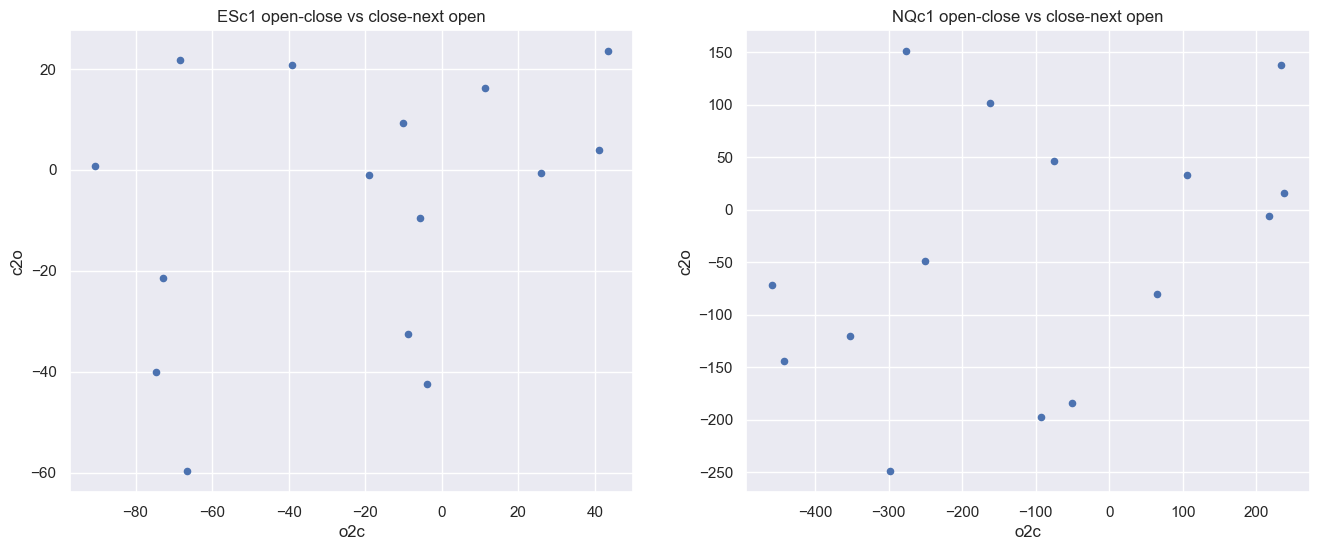

In [42]:
# there seems to be a relationship between those two prices, let's check with some scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
first_last_next.loc["ESc1"].plot.scatter(x="o2c", y="c2o", ax=ax1)
ax1.set_title("ESc1 open-close vs close-next open")
first_last_next.loc["NQc1"].plot.scatter(x="o2c", y="c2o", ax=ax2)
ax2.set_title("NQc1 open-close vs close-next open")

In [43]:
# nothing seems to come out of this..

## 3.3 Bid and Ask sizes analysis

### 3.3.1 Bid 

In [44]:
bid_sizes = train_df["bid_size"].unstack("symbol")

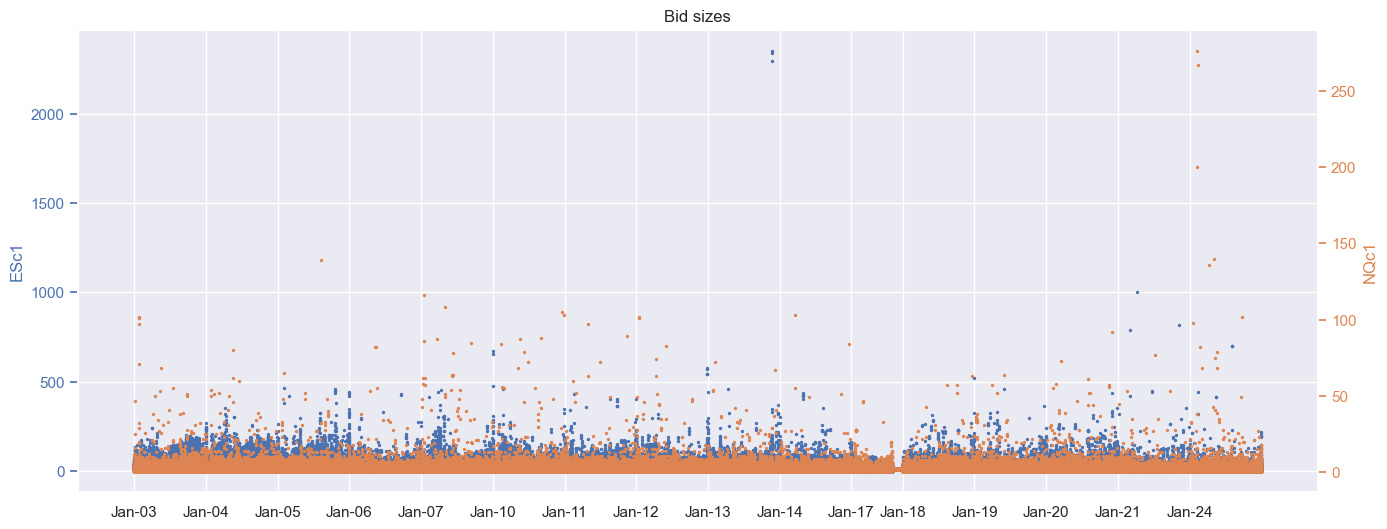

In [45]:
# checking distribution of bids throughout time
ax = graph_continuous(
    bid_sizes["ESc1"], 
    bid_sizes["NQc1"], 
    kind="scatter", 
    title="Bid sizes",
    labels=["ESc1", "NQc1"]
)

Text(0.5, 1.0, 'Bid size distribution for NQc1')

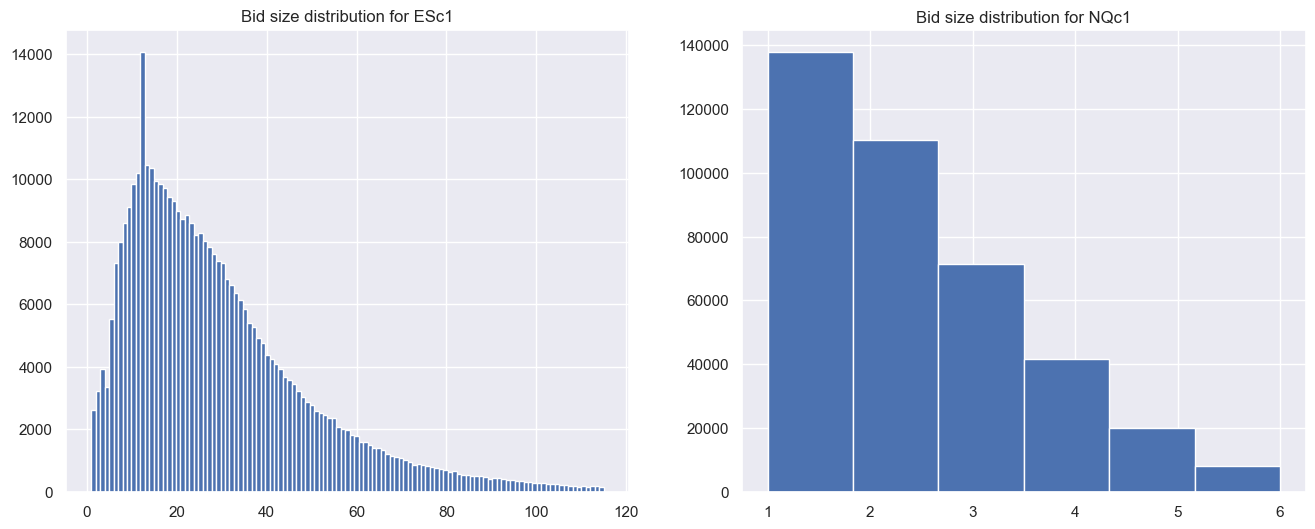

In [46]:
# as it seems stationnary,  let's look at the distribution on the whole period 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
no_outlier_bids1 = bid_sizes["ESc1"][bid_sizes["ESc1"] < bid_sizes["ESc1"].quantile(0.99)]
no_outlier_bids1.hist(bins=no_outlier_bids1.nunique(), ax=ax1)
ax1.set_title("Bid size distribution for ESc1")
no_outlier_bids2 = bid_sizes["NQc1"][bid_sizes["NQc1"] < bid_sizes["NQc1"].quantile(0.99)]
no_outlier_bids2.hist(bins=no_outlier_bids2.nunique(), ax=ax2)
ax2.set_title("Bid size distribution for NQc1")

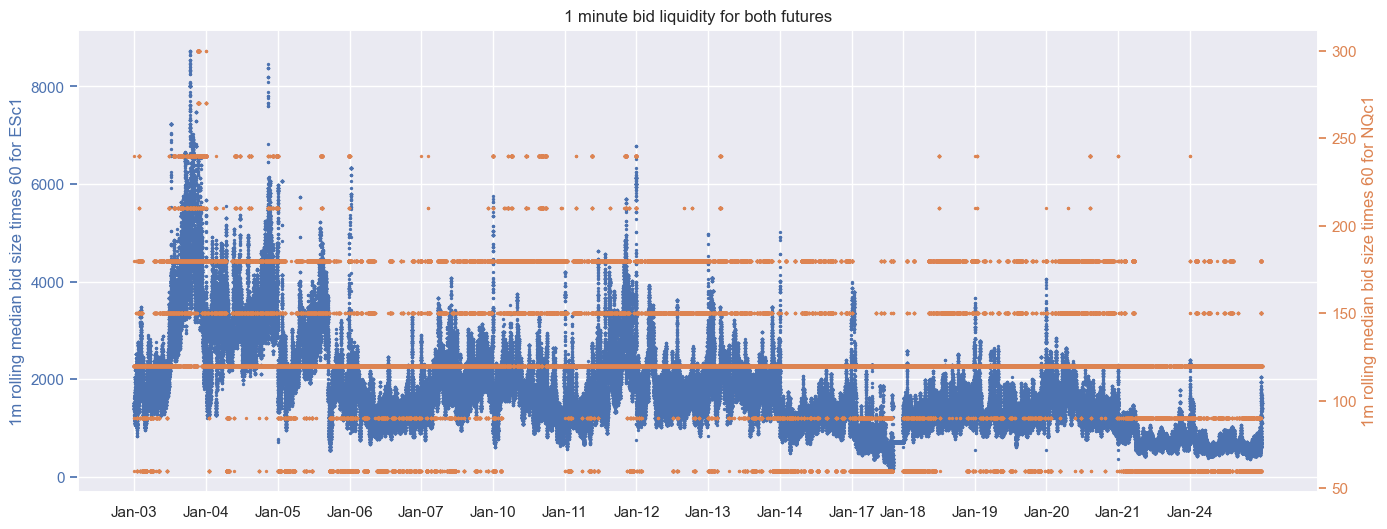

In [47]:
# let's see the liquidity on 1min time frame looks like
rolling_bids = bid_sizes.rolling("1T").median().mul(60).astype('int')
ax = graph_continuous(
    rolling_bids["ESc1"],
    rolling_bids["NQc1"],
    kind="scatter",
    title="1 minute bid liquidity for both futures",
    labels=["1m rolling median bid size times 60 for ESc1", "1m rolling median bid size times 60 for NQc1"]
)

Text(0.5, 1.0, 'Bid liquidity distribution for NQc1')

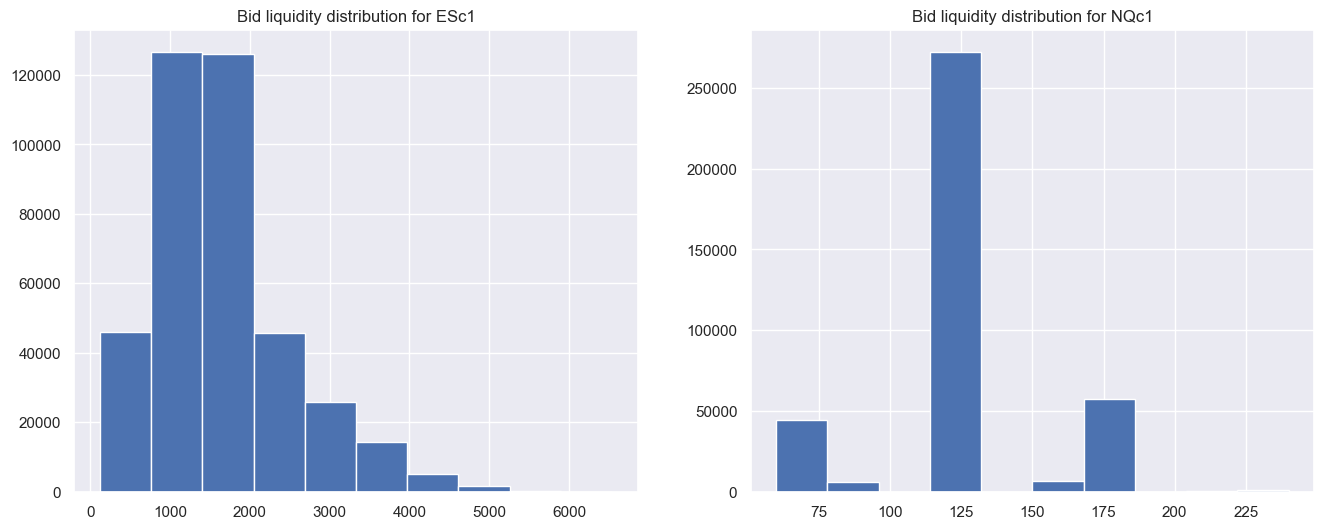

In [48]:
# as it also seems quite stationnary,  let's look at the distribution on the whole period 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
no_outlier_bids1.rolling("1T").median().mul(60).astype('int').hist(ax=ax1)
ax1.set_title("Bid liquidity distribution for ESc1")
no_outlier_bids2.rolling("1T").median().mul(60).astype('int').hist(ax=ax2)
ax2.set_title("Bid liquidity distribution for NQc1")

### 3.3.2 Ask

In [49]:
ask_sizes = train_df["ask_size"].unstack("symbol")

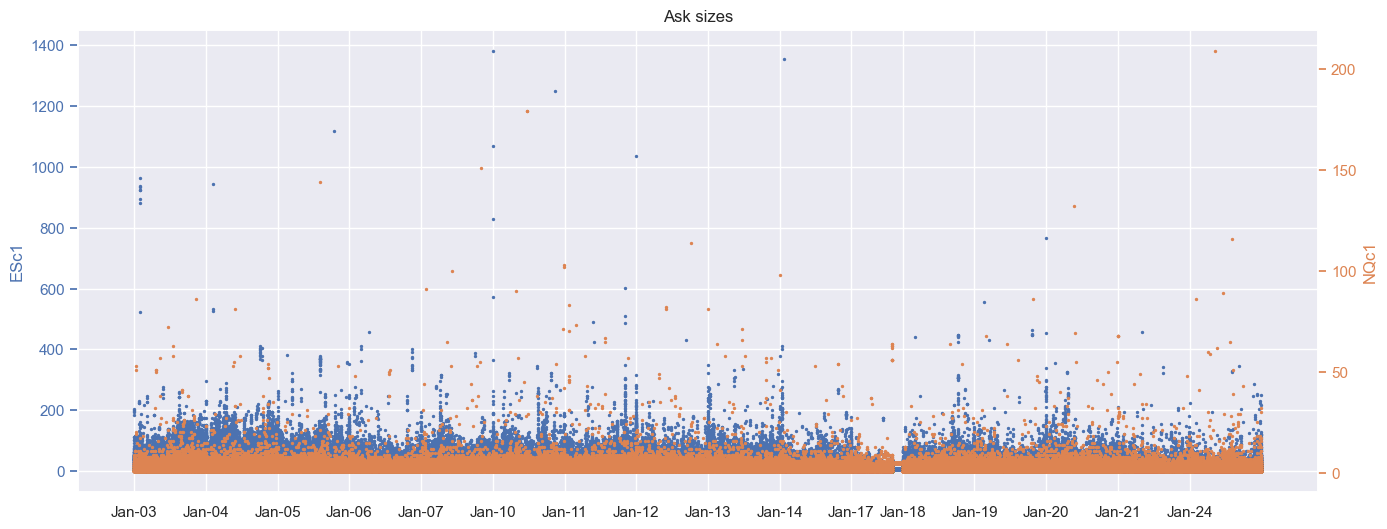

In [50]:
# checking distribution of asks throughout time
ax = graph_continuous(
    ask_sizes["ESc1"], 
    ask_sizes["NQc1"], 
    kind="scatter", 
    title="Ask sizes",
    labels=["ESc1", "NQc1"]
)

Text(0.5, 1.0, 'Ask size distribution for NQc1')

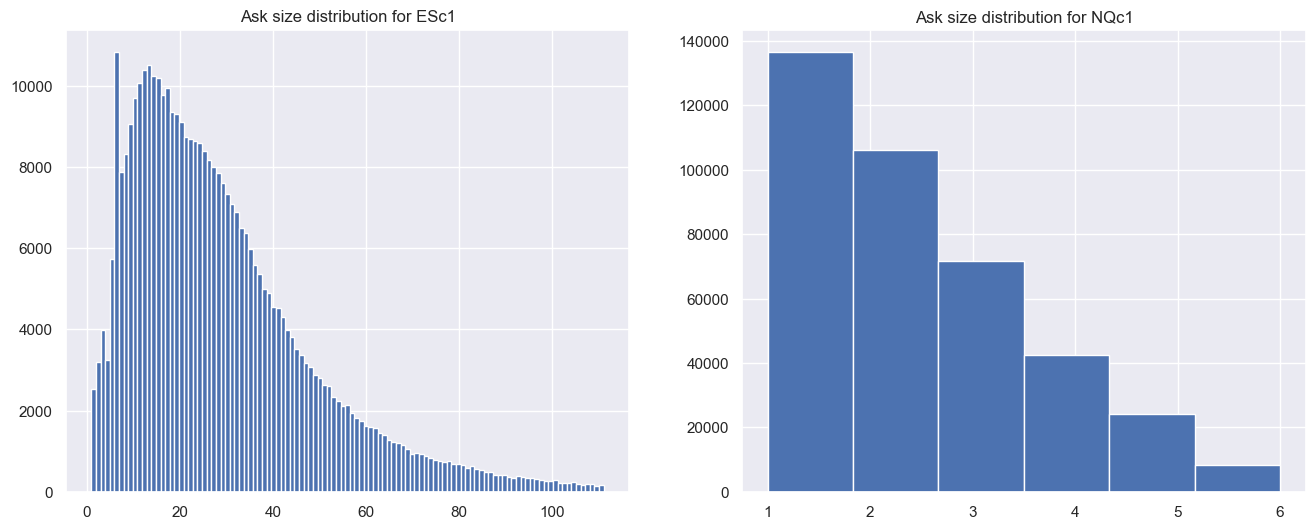

In [51]:
# as it seems stationnary,  let's look at the distribution on the whole period 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
no_outlier_asks1 = ask_sizes["ESc1"][ask_sizes["ESc1"] < ask_sizes["ESc1"].quantile(0.99)]
no_outlier_asks1.hist(bins=no_outlier_asks1.nunique(), ax=ax1)
ax1.set_title("Ask size distribution for ESc1")
no_outlier_asks2 = ask_sizes["NQc1"][ask_sizes["NQc1"] < ask_sizes["NQc1"].quantile(0.99)]
no_outlier_asks2.hist(bins=no_outlier_asks2.nunique(), ax=ax2)
ax2.set_title("Ask size distribution for NQc1")

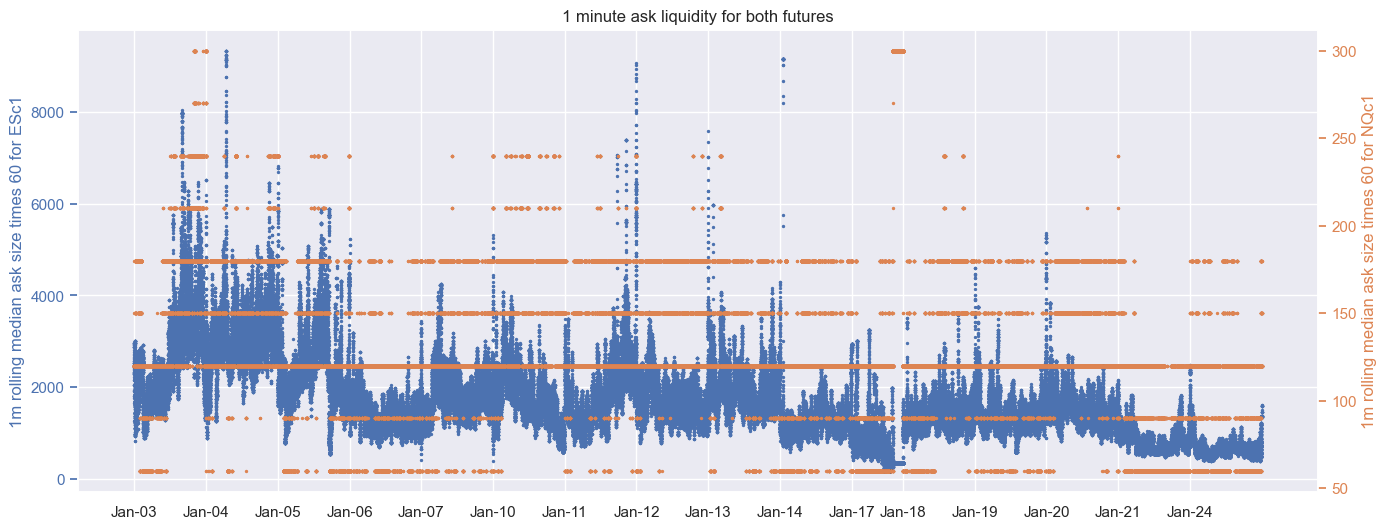

In [52]:
# let's see the liquidity on 1min time frame looks like
rolling_asks = ask_sizes.rolling("1T").median().mul(60).astype('int')
ax = graph_continuous(
    rolling_asks["ESc1"],
    rolling_asks["NQc1"],
    kind="scatter",
    title="1 minute ask liquidity for both futures",
    labels=["1m rolling median ask size times 60 for ESc1", "1m rolling median ask size times 60 for NQc1"]
)

Text(0.5, 1.0, 'Ask liquidity distribution for NQc1')

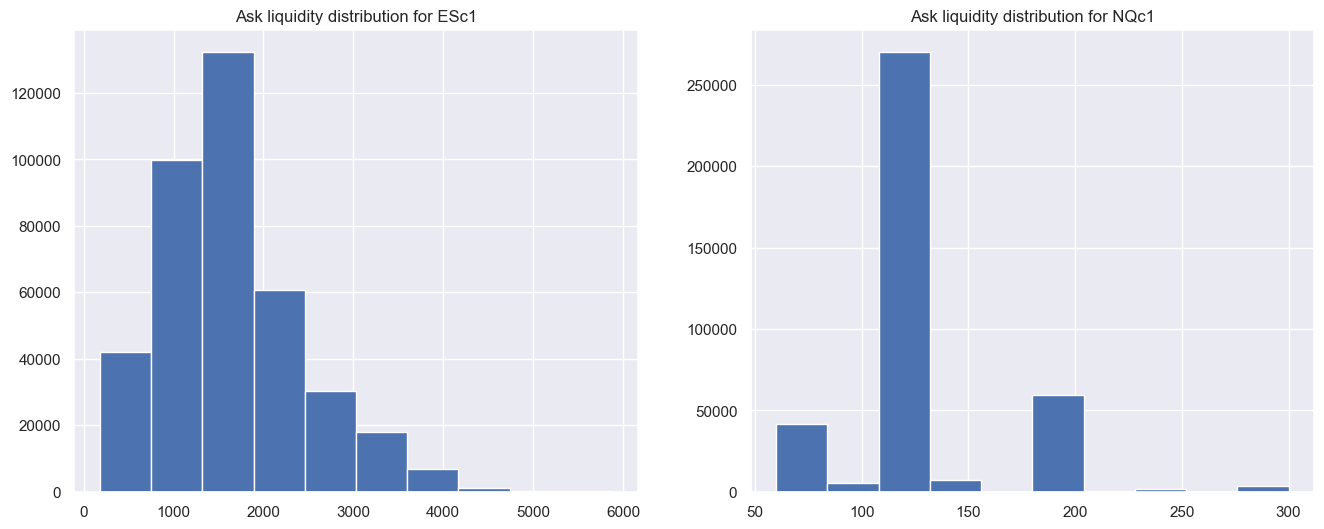

In [53]:
# as it also seems quite stationnary,  let's look at the distribution on the whole period 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
no_outlier_asks1.rolling("1T").median().mul(60).astype('int').hist(ax=ax1)
ax1.set_title("Ask liquidity distribution for ESc1")
no_outlier_asks2.rolling("1T").median().mul(60).astype('int').hist(ax=ax2)
ax2.set_title("Ask liquidity distribution for NQc1")

### 3.3.3 Ask vs Bid relationship

/var/folders/9w/vls_pj350g3b62pyz_4t5hp80000gn/T/ipykernel_92597/2889944086.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([str(p.date()) for p in rolling_bids[::len(rolling_bids)//10].index])


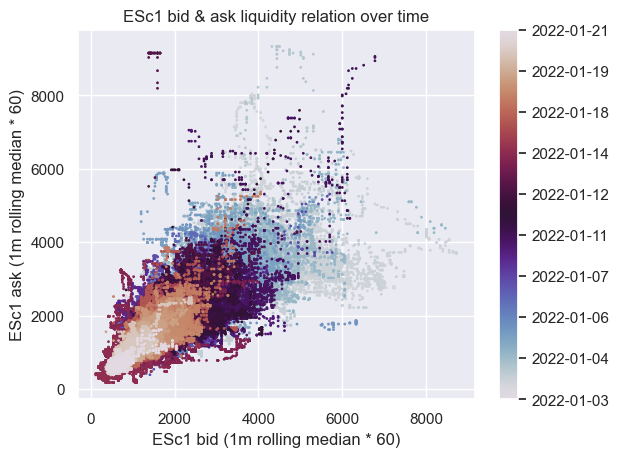

In [54]:
# let's check if liquidity is symmetric
points = plt.scatter(rolling_bids["ESc1"], rolling_asks["ESc1"], c=np.linspace(0.1, 1, len(rolling_bids)), s=1, cmap="twilight")
cbar = plt.colorbar(points)
cbar.ax.set_yticklabels([str(p.date()) for p in rolling_bids[::len(rolling_bids)//10].index])
plt.xlabel("ESc1 bid (1m rolling median * 60)")
plt.ylabel("ESc1 ask (1m rolling median * 60)")
_ = plt.title("ESc1 bid & ask liquidity relation over time")

/var/folders/9w/vls_pj350g3b62pyz_4t5hp80000gn/T/ipykernel_92597/2161958614.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([str(p.date()) for p in rolling_bids[::len(rolling_bids)//10].index])


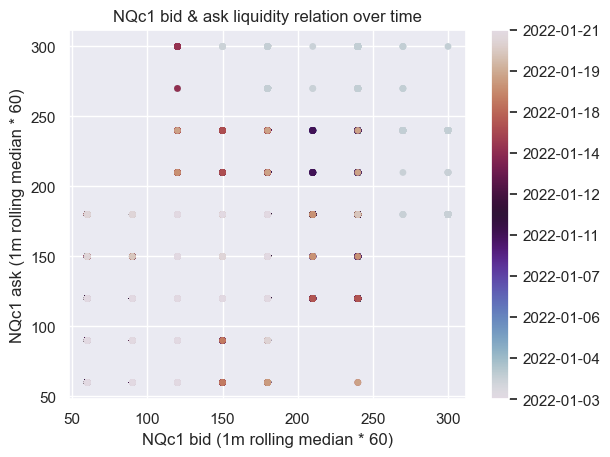

In [55]:
# let's check if liquidity is symmetric
points = plt.scatter(rolling_bids["NQc1"], rolling_asks["NQc1"], c=np.linspace(0.1, 1, len(rolling_bids)), s=15, cmap="twilight")
cbar = plt.colorbar(points)
cbar.ax.set_yticklabels([str(p.date()) for p in rolling_bids[::len(rolling_bids)//10].index])
plt.xlabel("NQc1 bid (1m rolling median * 60)")
plt.ylabel("NQc1 ask (1m rolling median * 60)")
_ = plt.title("NQc1 bid & ask liquidity relation over time")

In [56]:
# seems quite symmetric even if it's harder to see on the NQc1

## 3.4 Bid-Ask Spread

In [57]:
train_df["bid_ask_spread"] = train_df["ask_price"] - train_df["bid_price"]

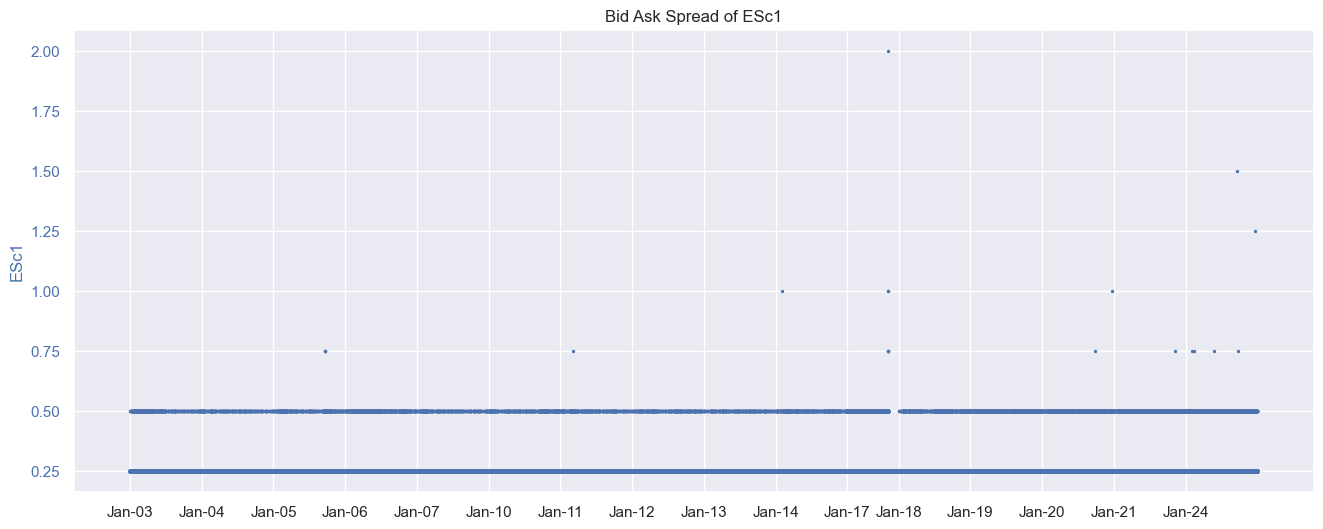

In [58]:
# plotting bid ask spread for ESc1
ax = graph_continuous(
    train_df["bid_ask_spread"].loc["ESc1"], 
    kind="scatter", 
    title="Bid Ask Spread of ESc1",
    labels=["ESc1"]
)

In [59]:
# large tick: almost always 0.25 or 0.5

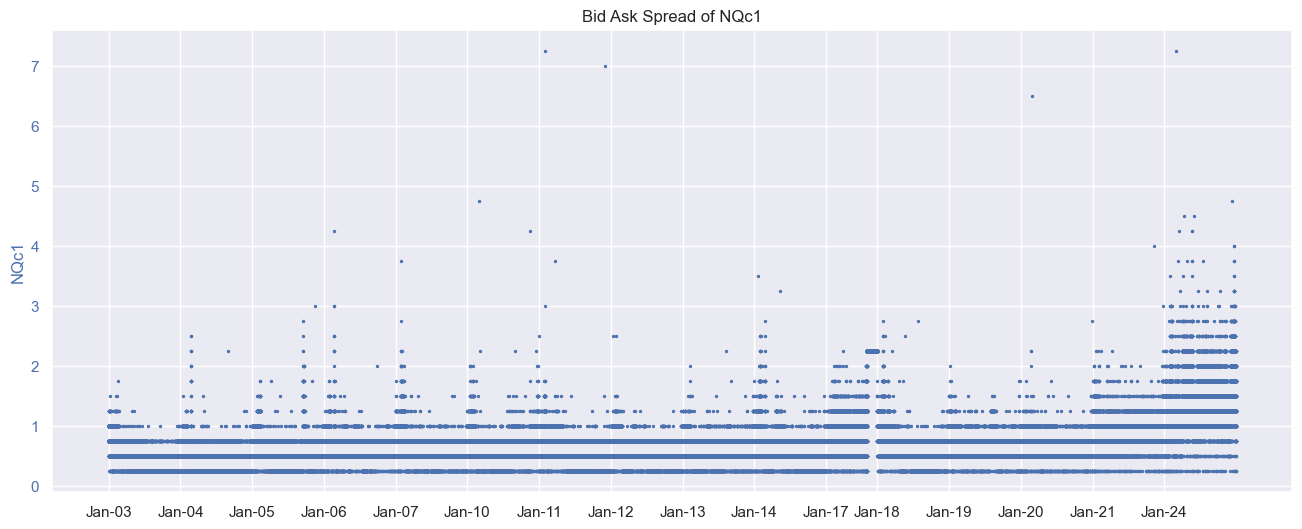

In [60]:
# plotting bid ask spread for NQc1
ax = graph_continuous(
    train_df["bid_ask_spread"].loc["NQc1"], 
    kind="scatter", 
    title="Bid Ask Spread of NQc1",
    labels=["NQc1"]
)

In [61]:
# small tick: greatly varing

# 4. Spread Mean Reversion

## 4.1 First analysis

### 4.1.1 Spread fitting on whole period

In [62]:
# the goal is to see if NQc1 - h * ESc1 has some mean reverting propreties, h being the hedge ratio. 
# for now, we will fit h on the whole series, but in reality, h cannot be computed like so, 
# otherwise there would be a strong lookahead bias

In [63]:
ols = sm.OLS(mid_prices["NQc1"], mid_prices["ESc1"])
ols_res = ols.fit()
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   NQc1   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.110e+09
Date:                Tue, 05 Mar 2024   Prob (F-statistic):                        0.00
Time:                        01:21:08   Log-Likelihood:                     -2.6078e+06
No. Observations:              396000   AIC:                                  5.216e+06
Df Residuals:                  395999   BIC:                                  5.216e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ESc1           3.3521   6.01e-05   5.58e+04      0.000       3.352       3.352
==============================================================================
Omnibus:                    29983.937   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40270.558
Skew:                           0.661   Prob(JB):                         0.00
Kurtosis:                       3.833   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
# the fit is very strong, there's a clear linear relationship

In [65]:
total_spread = mid_prices["NQc1"] - ols.predict(ols_res.params)

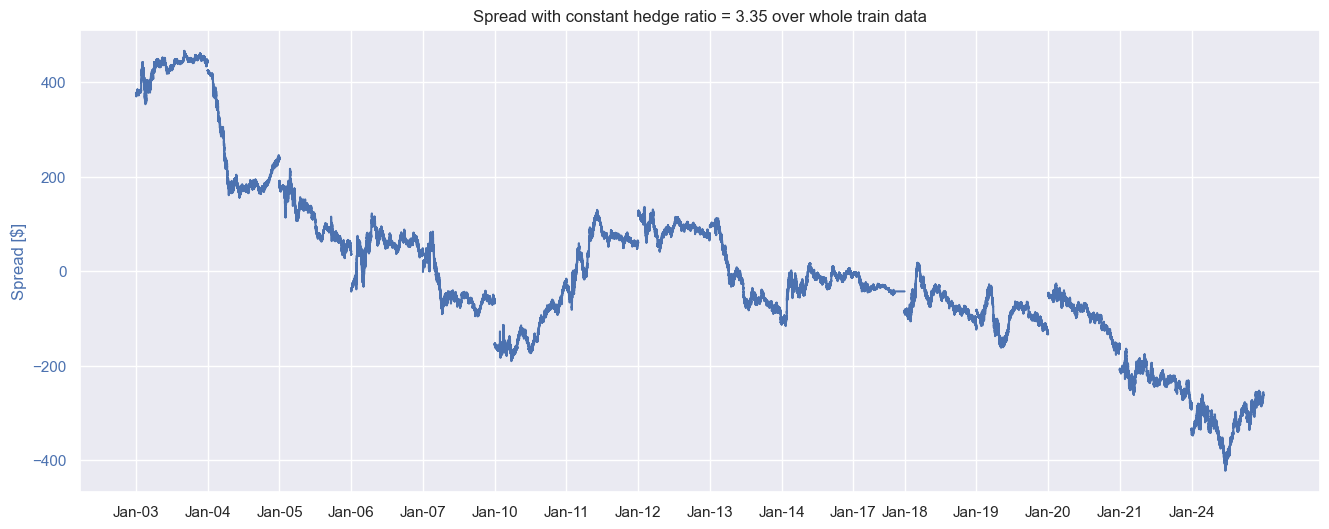

In [66]:
# let's plot the evoluation of the spread
ax = graph_continuous(
    total_spread,
    title=f"Spread with constant hedge ratio = {np.round(ols_res.params['ESc1'], 2)} over whole train data",
    labels=["Spread [$]"]
)

In [67]:
# mean reversion doesn't seem very strong on the whole period, but some days seem quite stationnary, except on a few days

In [68]:
# let's check if a constant would make sense to add in the OLS model
total_spread.mean()

-4.0790882532738175

### 4.1.2 Spread fitting on each period

In [69]:
# let's try the same on a daily basis, maybe fitting only one ratio is too simplistic

In [70]:
# fitting hedge ratio each day
daily_hedge_ratio = pd.Series(index=mid_prices.index)
for day, data in mid_prices.groupby(pd.Grouper(freq="1D")):
    if data.shape[0] == 0:
        continue
    ols = sm.OLS(data["NQc1"], data["ESc1"])
    ols_res = ols.fit()
    daily_hedge_ratio.loc[day.strftime("%Y-%m-%d")] = ols_res.params["ESc1"]

In [71]:
daily_ajusted_spread = mid_prices["NQc1"] - daily_hedge_ratio * mid_prices["ESc1"]

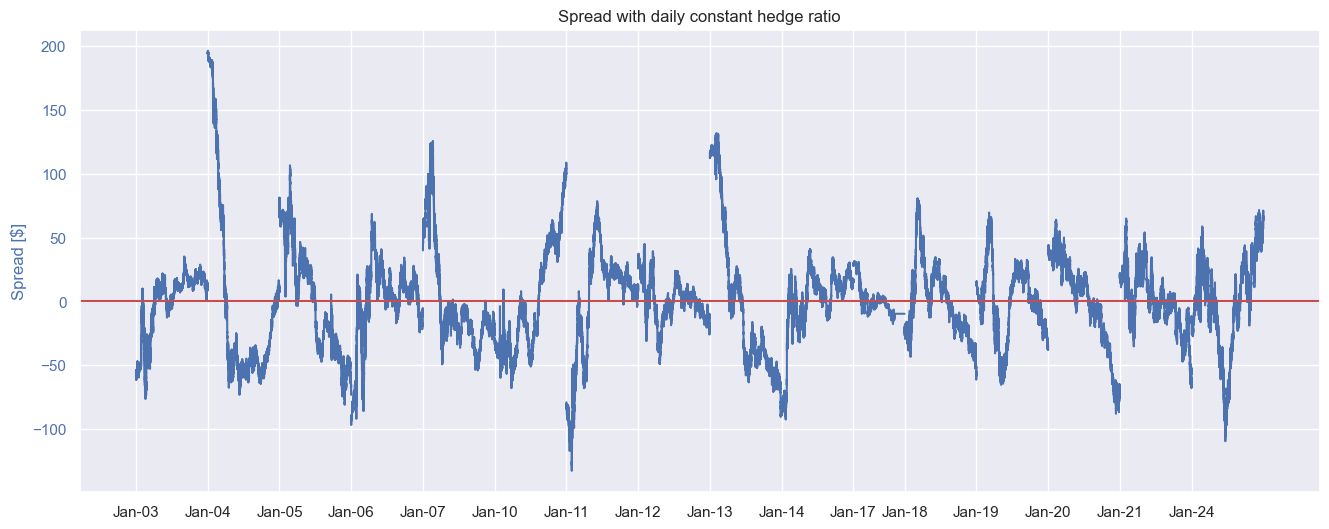

In [72]:
ax = graph_continuous(
    daily_ajusted_spread,
    title=f"Spread with daily constant hedge ratio",
    labels=["Spread [$]"]
)
ax.axhline(0, color="r")

In [73]:
# this makes actual sense: we are fitting each day and computing the residual each day, so OLS will give something stationnar
# what is interesting to see is if there's some mean reversion going on


In [74]:
# let's check with Hurst component
H, *_ = compute_Hc(daily_ajusted_spread.dropna())
H

0.45173540323516037

In [75]:
# there's some mean reversion for sure

## 4.2 Analysis wihtout leakage (nor lookahead bias)

In [76]:
# to avoid leakage h needs to be fitted on a window and then evaluated on another window that is after the first one
# this means I need to do an iterative fit
# "freq_split" allows to give slices of the data. step gives the step of the iterative fit, max_window gives the window on which the fit is done 

### 4.2.0 Helper functions

In [77]:
def train_val_iter(data, step, window):
    """
    Generates training and validation intervals for time series data
    Adjusts for irregular time intervals between data points, ensuring consistent training window sizes
    For example: if window="4H", the first validation period of a given day will have as train period, the last 4 hours
    of data of the last trading day

    WARNING: this function only works with frequencies that are at most in hours. If you want a window of 3D, please use
    "XH" where X = 3 * number of trading hours per day

    Parameters:
    - data (pd.DataFrame): Time series data with datetime index
    - step (str): Size of validation set (the increase in step), must be a pandas-compatible frequency string 
    - window (str): Size of the training window as a pandas-compatible frequency string.

    Yields:
    - tuple(pd.Timestamp, pd.Timestamp, pd.Timestamp, pd.Timestamp): Each yield returns a tuple containing:
      - train_start (pd.Timestamp): Start timestamp of the training interval
      - train_end (pd.Timestamp): End timestamp of the training interval, just before validation starts
      - val_start (pd.Timestamp): Start timestamp of the validation interval
      - val_end (pd.Timestamp): End timestamp of the validation interval

    """
    
    # convert step and window to timedelta
    one_sec = pd.Timedelta('1s')
    step_delta = pd.Timedelta(step)
    window_delta = pd.Timedelta(window) 

    # calculate time jumps between data (end of day to start of next day for example)
    time_jumps = data.index.to_series().diff().fillna(one_sec)
    # keep only the jumps that are not one second (so not continuous data)
    corrections = (time_jumps - one_sec)

    # identify validation start times, depending on step size
    val_starts = data.index[data.resample(step)._grouper.bins[:-1]].unique()
    first_train_start = data.index[0]

    # iterate over validation starts to yield train and val intervals
    for val_start in val_starts:
        
        # set end of validation period and start of train interval
        val_end = val_start + step_delta
        train_end = val_start - one_sec

        # set naive train_start (by window size)
        old_train_start = train_end - window_delta + one_sec
        # get the correction (sum of sizes of time jumps that are not 1s)
        correction = corrections.loc[old_train_start+one_sec: train_end+one_sec].sum()
        # correct size
        train_start = val_start - correction - window_delta
        
        # while there remains some corrections with updated train_start, update again
        while correction := corrections.loc[train_start+one_sec: old_train_start].sum():
            old_train_start = train_start
            train_start = old_train_start - correction
            
        # skip if train start before data start
        if train_start < first_train_start:
            continue

        # yield the slices
        yield train_start, train_end, val_start, val_end

In [78]:
def no_leakage_ols_spread(mid_prices, step="1H", window=None):
    """
    Fits an OLS model iteratively without lookahead bias to compute the spread and hedge ratio.

    Parameters:
    - mid_prices (pd.DataFrame): Mid prices both for ESc1 and NQc1
    - step (str): Incremental step for fitting as pandas frequency string (e.g., '1H').
    - max_window (str or None): Size of the fitting window as pandas frequency string. None for full span.

    Returns:
    - hedge_ratio (pd.Series): Fitted hedge ratio over time.
    - spread (pd.Series): Spread with fitted hedge ratio on previous step.

    Fits an OLS model on slices of data defined by `step` and `max_window`, updating the hedge ratio and spread
    for subsequent slices to prevent lookahead bias.
    """
    # initialize outputs
    hedge_ratio = pd.Series(index=mid_prices.index)
    spread = pd.Series(index=mid_prices.index)
    # store variables for fitting
    X = mid_prices["ESc1"]
    Y = mid_prices["NQc1"]

    # iterate over each period defined by step
    for fit_start, fit_end, eval_start, eval_end in tqdm(train_val_iter(mid_prices, step=step, window=window)):
        # fit ols on fitting period
        ols = sm.OLS(Y.loc[fit_start:fit_end], X.loc[fit_start:fit_end])
        ols_res = ols.fit()
        # evaluate on evaluation period
        hedge_ratio.loc[eval_start:eval_end] = ols_res.params["ESc1"]
        spread.loc[eval_start:eval_end] = Y - X.loc[eval_start: eval_end] * ols_res.params["ESc1"]
    return hedge_ratio, spread

In [79]:
def plot_hedge_spread_period(hedge_ratio, spread, freq, span, num_samples=3):
    """ Plots random samples of the hedge ratio and spread on a smaller time frame, that can be set by freq and span"""
    end_of_day = pd.Timestamp("21:00").time()
    span_td = pd.Timedelta(span)
    groups = hedge_ratio.groupby(pd.Grouper(freq=freq))
    sample_keys = np.random.choice([
        key for key, group in groups if not group.empty and (key + span_td).time() < end_of_day
    ], size=num_samples, replace=False)
    fig, axes = plt.subplots(len(sample_keys), 1, figsize=(12, 3 * len(sample_keys)))
    for k, ax in zip(sample_keys, axes):
        hedge_ratio.loc[k:k + span_td].plot(ax=ax, title=f"{k} to {k+span_td}")
        spread.loc[k:k + span_td].plot(ax=ax, secondary_y=True)
    plt.tight_layout()

### 4.2.1 First fit

In [80]:
hedge_ratio1, spread1 = no_leakage_ols_spread(mid_prices, step="1H", window="14H")

0it [00:00, ?it/s]

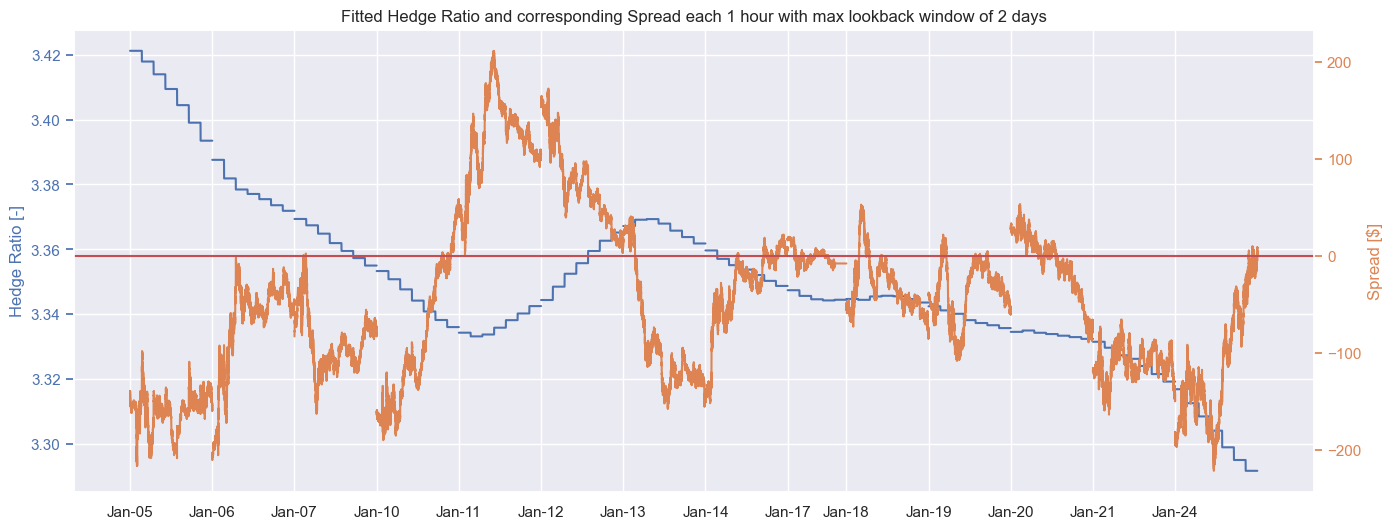

In [81]:
ax = graph_continuous(
    hedge_ratio1,
    spread1,
    title="Fitted Hedge Ratio and corresponding Spread each 1 hour with max lookback window of 2 days",
    labels=["Hedge Ratio [-]", "Spread [$]"]
)
ax[1].axhline(0, color="r")

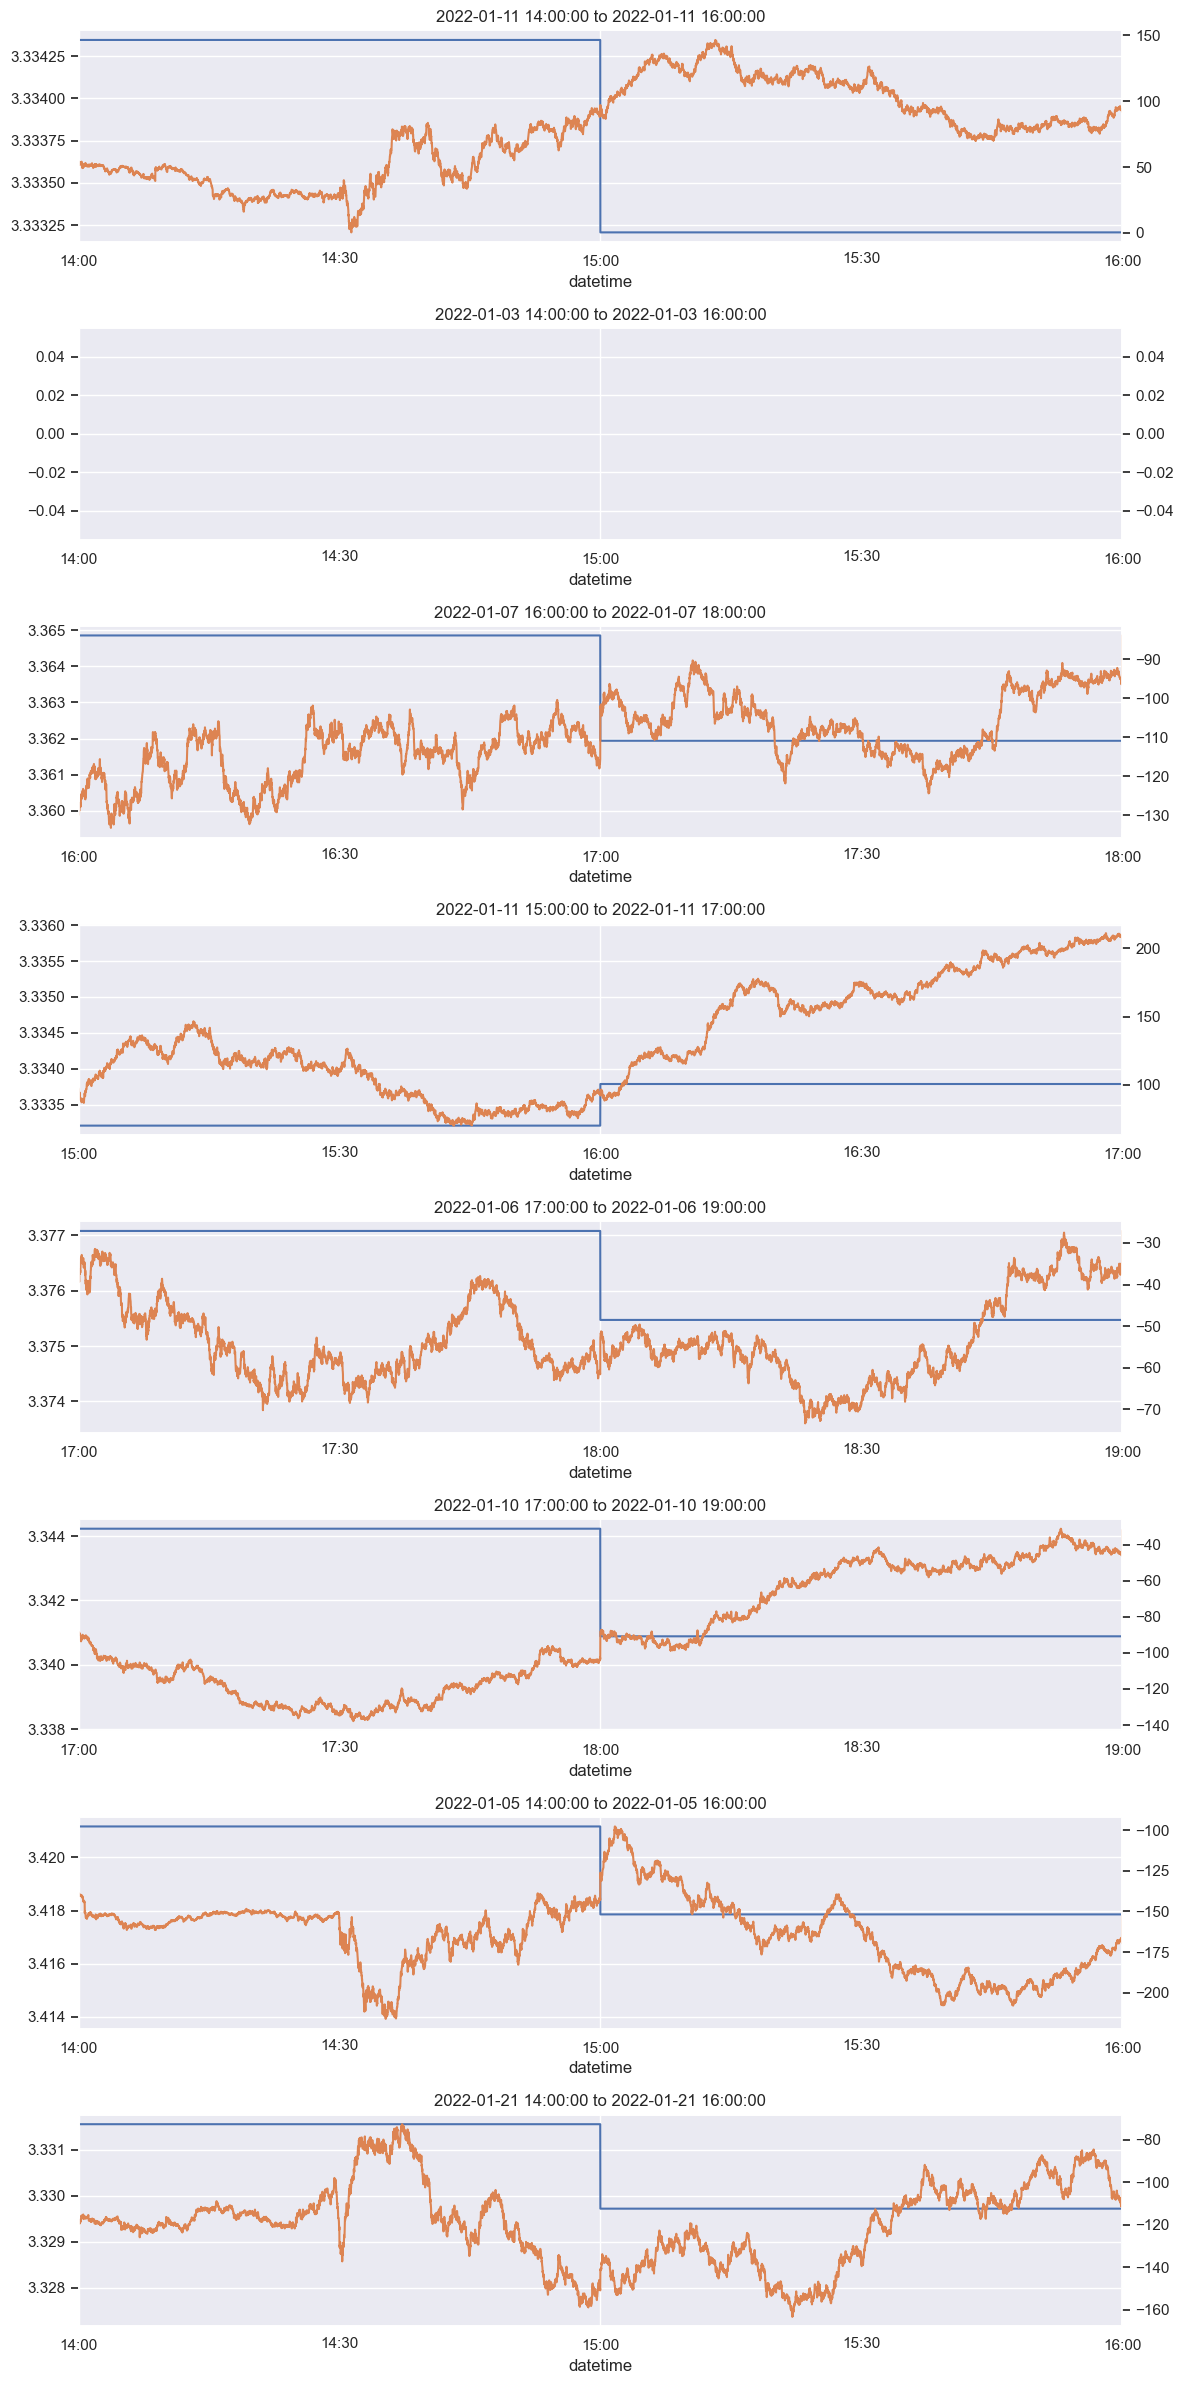

In [82]:
plot_hedge_spread_period(hedge_ratio1, spread1, freq="1H", span="2H", num_samples=8)

In [83]:
# during some periods, the spread seems to be quite mean reverting, while on some others, there are clear trends

# but more interestingly, large changes in the hedge_ratio yields a sharp dislocation in the spread
# this means that it will surely yield buy or sell signals just because of that change in the hedge ratio, 
# let's try to reduce the window and step

### 4.2.2: More frequent fit

In [84]:
hedge_ratio2, spread2 = no_leakage_ols_spread(mid_prices, step="1T", window="15T")

0it [00:00, ?it/s]

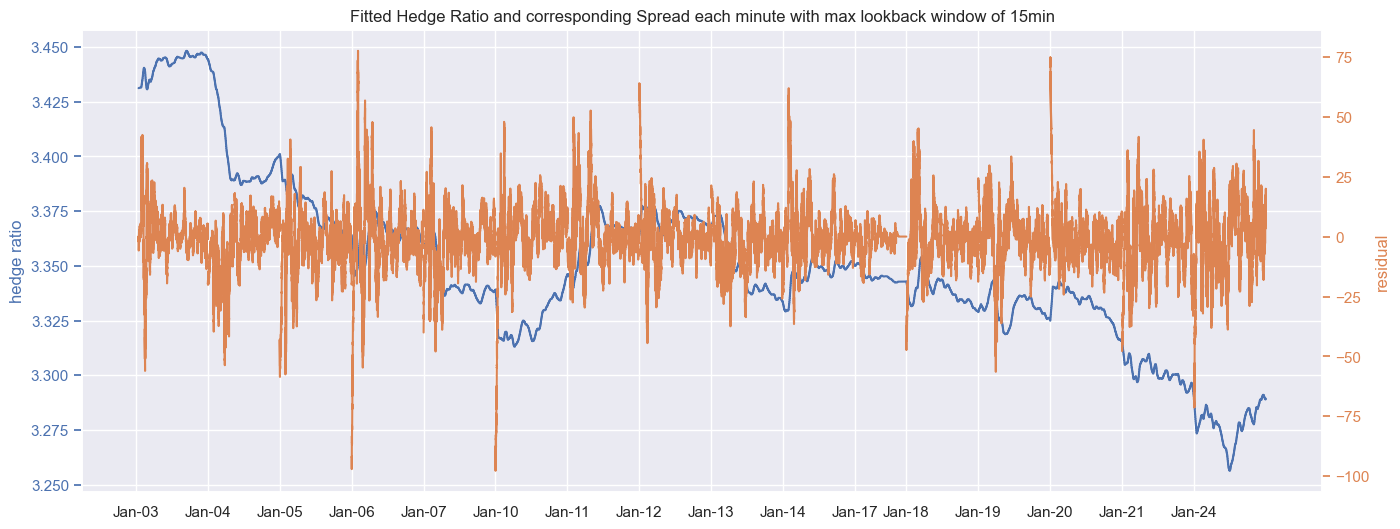

In [85]:
ax = graph_continuous(
    hedge_ratio2,
    spread2,
    title="Fitted Hedge Ratio and corresponding Spread each minute with max lookback window of 15min",
    labels=["hedge ratio", "residual"]
)

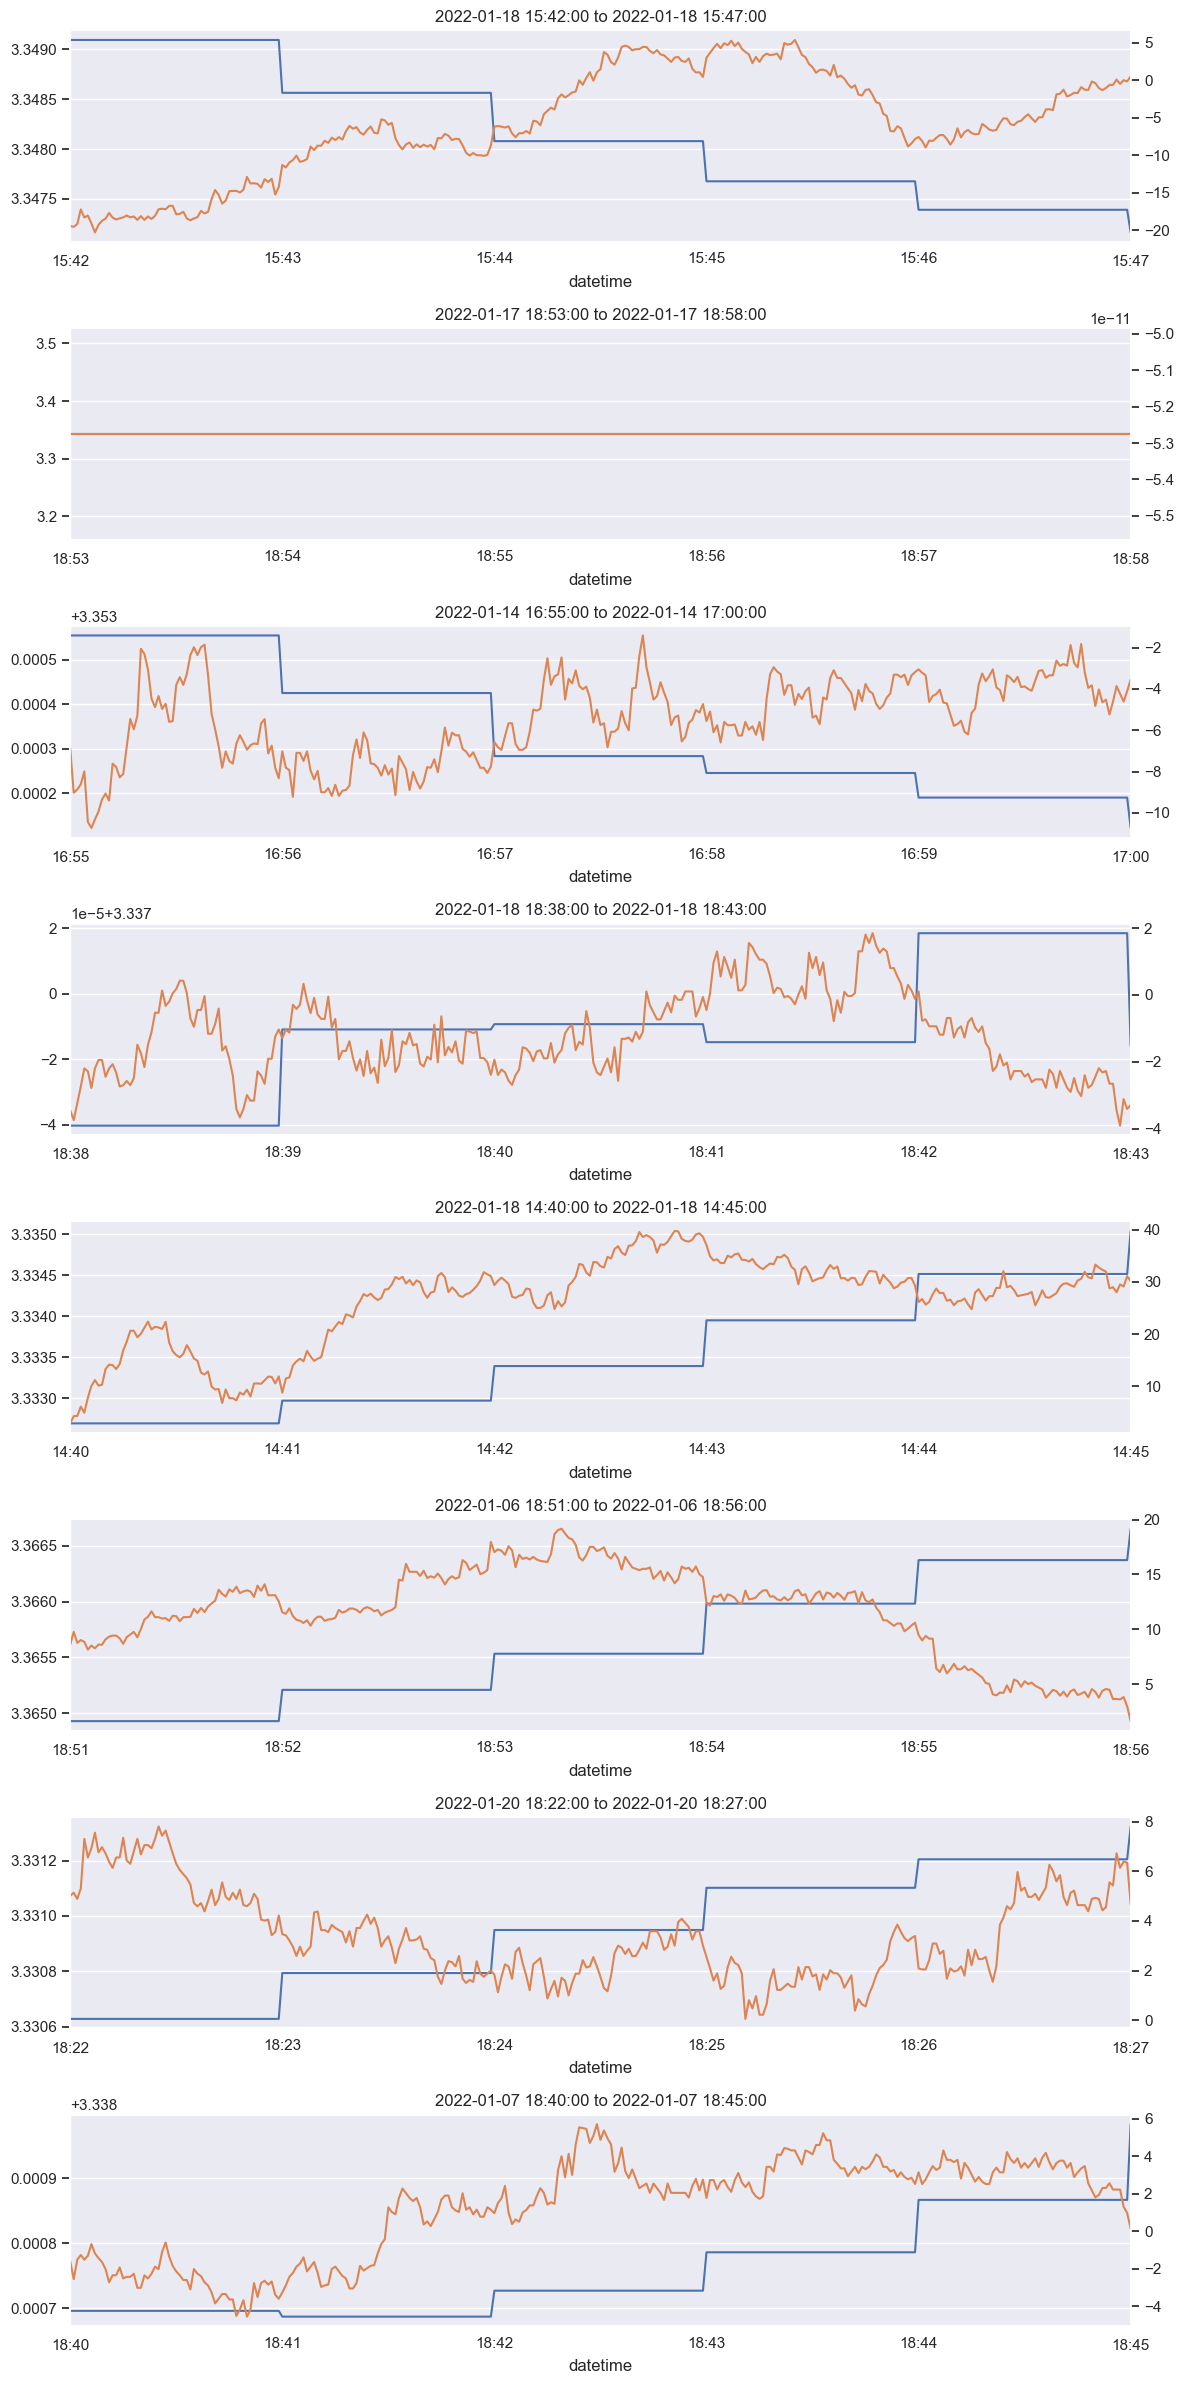

In [86]:
plot_hedge_spread_period(hedge_ratio2, spread2, freq="1T", span="5T", num_samples=8)

In [87]:
# even though this is quite mean reverting, the actual ratio is very precise and the mean reversion is happening fast
# this means that we won't have time to actually build a position before the reversion will happened
# also, the scale of the spread is very low

# we need to find a frequency in between the two we tried 

### 4.2.3: Fit in between

In [88]:
hedge_ratio3, spread3 = no_leakage_ols_spread(mid_prices, step="15T", window="3H")

0it [00:00, ?it/s]

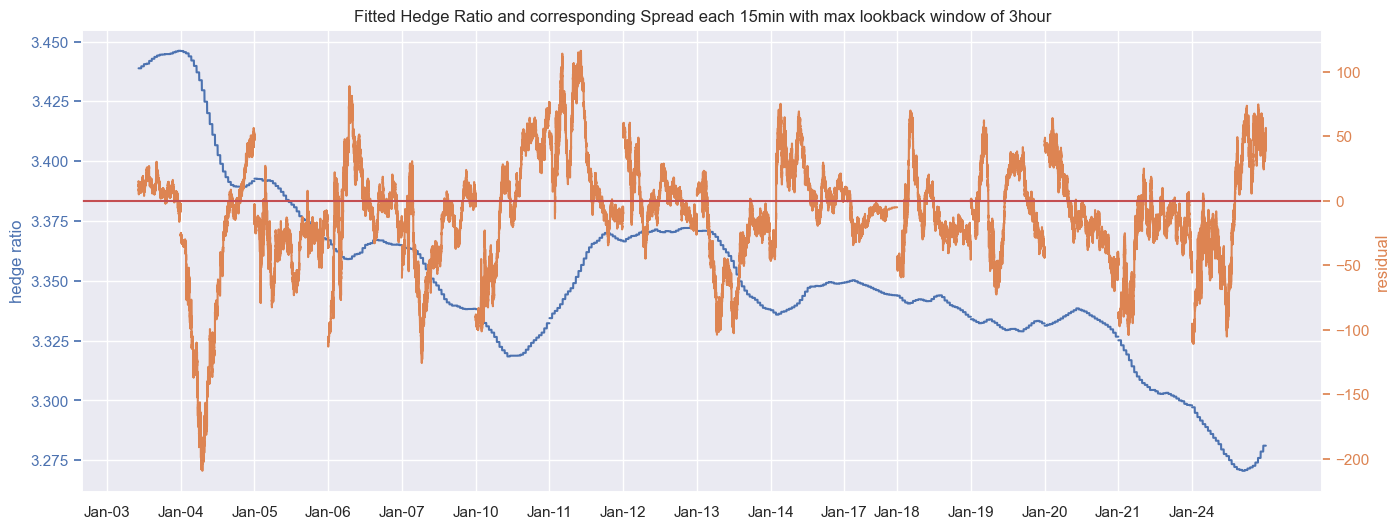

In [89]:
ax = graph_continuous(
    hedge_ratio3,
    spread3,
    title="Fitted Hedge Ratio and corresponding Spread each 15min with max lookback window of 3hour",
    labels=["hedge ratio", "residual"]
)
ax[1].axhline(0, color="r")

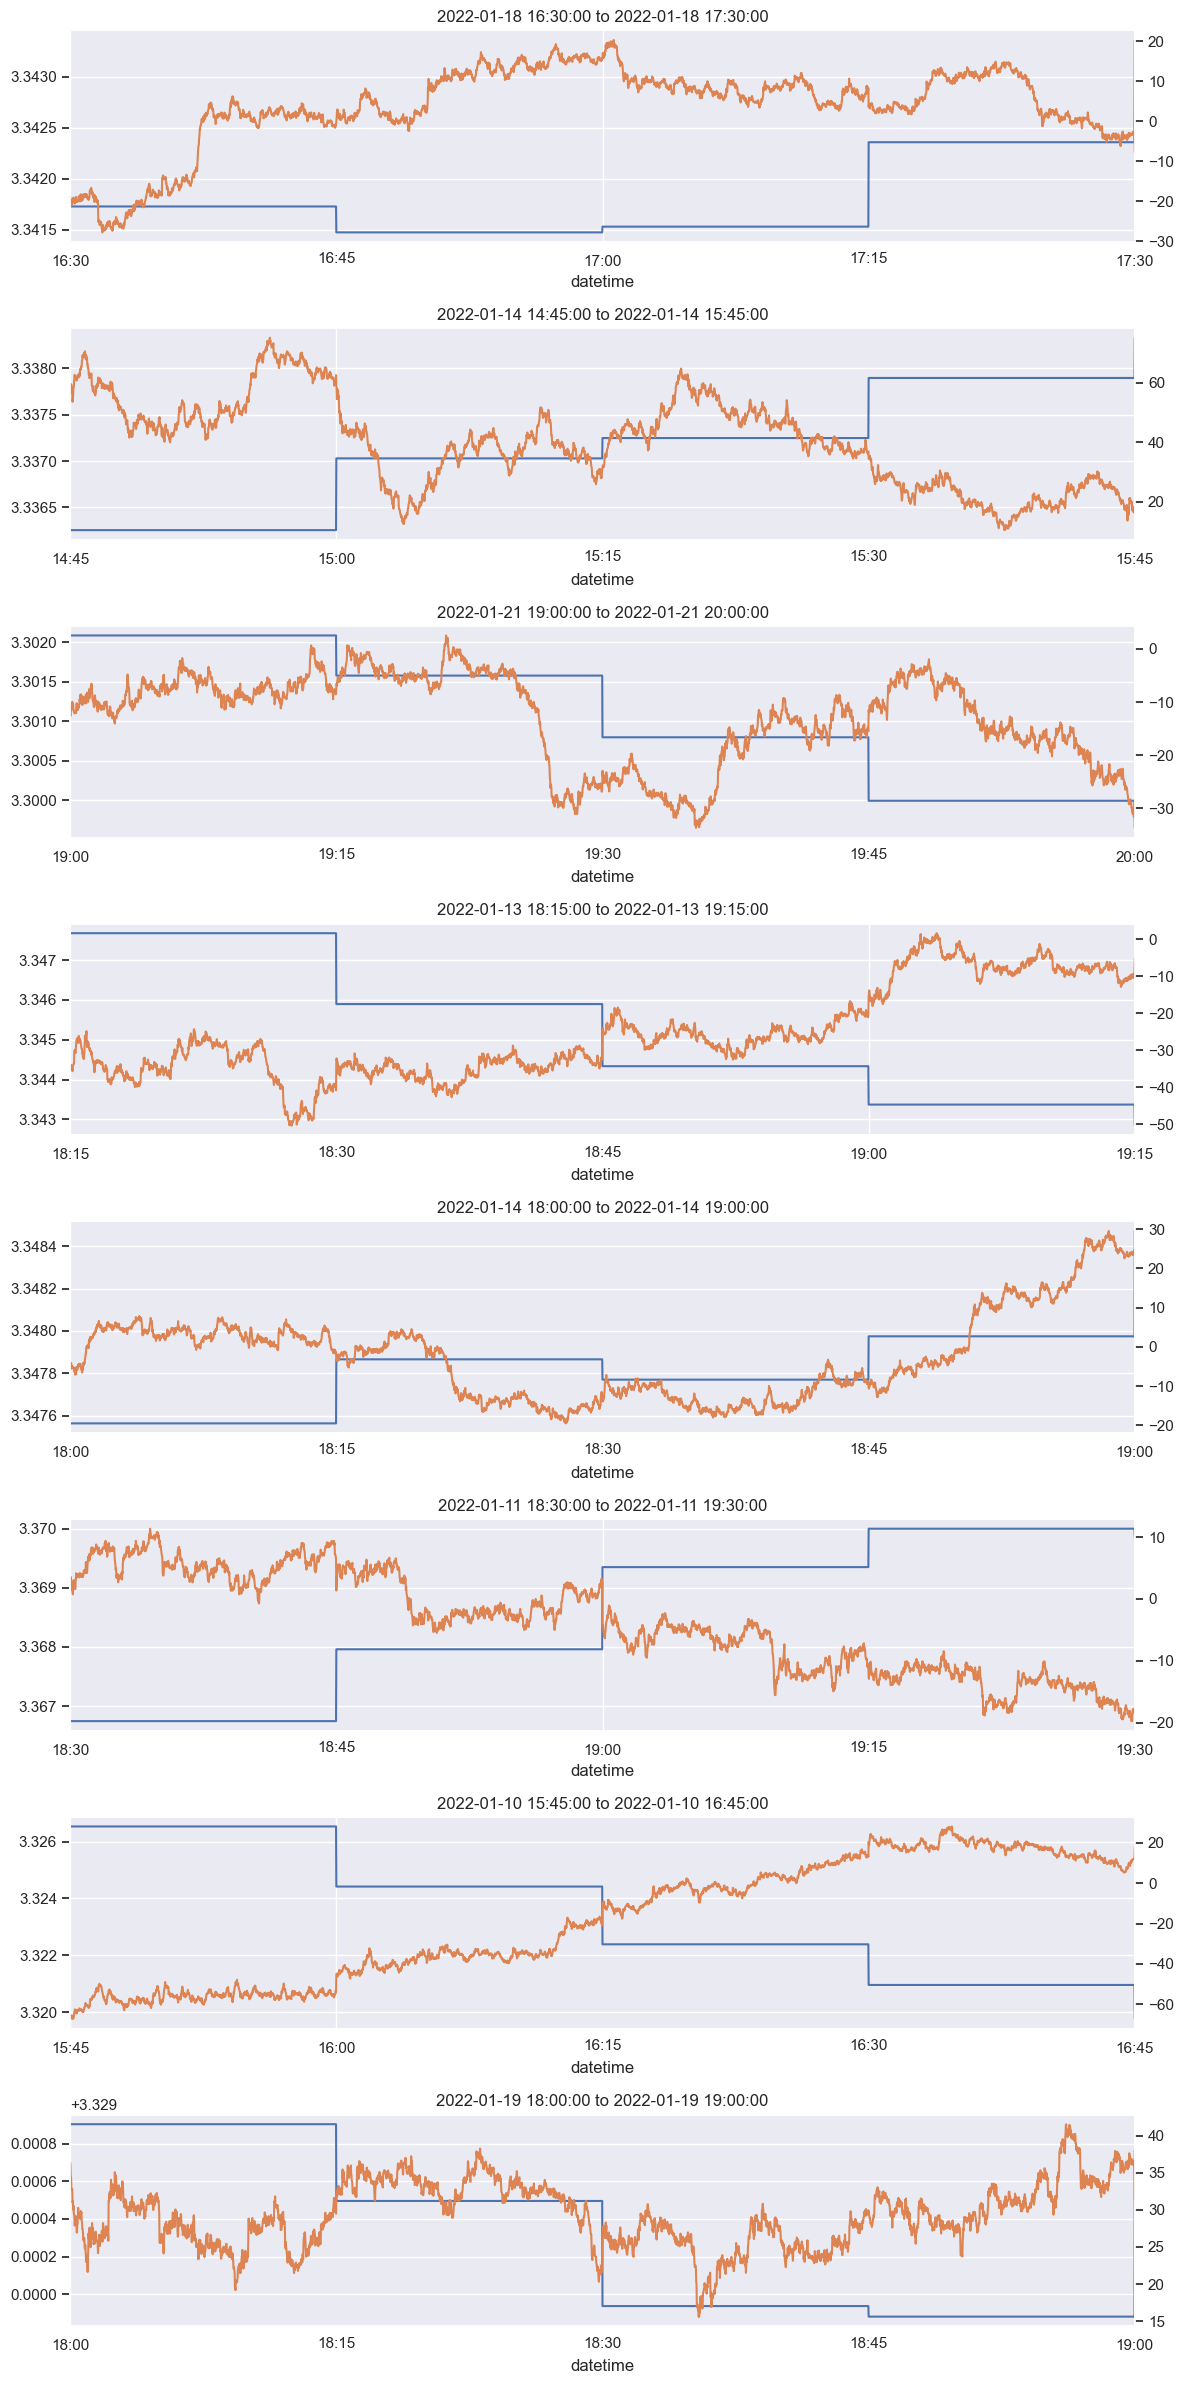

In [90]:
plot_hedge_spread_period(hedge_ratio3, spread3, freq="15T", span="1H", num_samples=8)

In [91]:
# this is quite good: there's mean reverting happening and there's enough time to build a posotion with the liquidity

In [92]:
# if I had more time, I would have done a grid search, but I will stick to this for now

## 4.3 Building and evaluating trading signals

In [93]:
# for now, let's don't into account cost of trading for the dynamic hedging, liquidity, market impact and slippage. 
# This means that we could go long or short the spread precisely
# My buy and sell signals will simply be when a exponential weighted moving zscore is above or below a threshold

In [94]:
spread_ewm = spread3.ewm(halflife=360)
spread_zscore = (spread3 - spread_ewm.mean()) / spread_ewm.std()

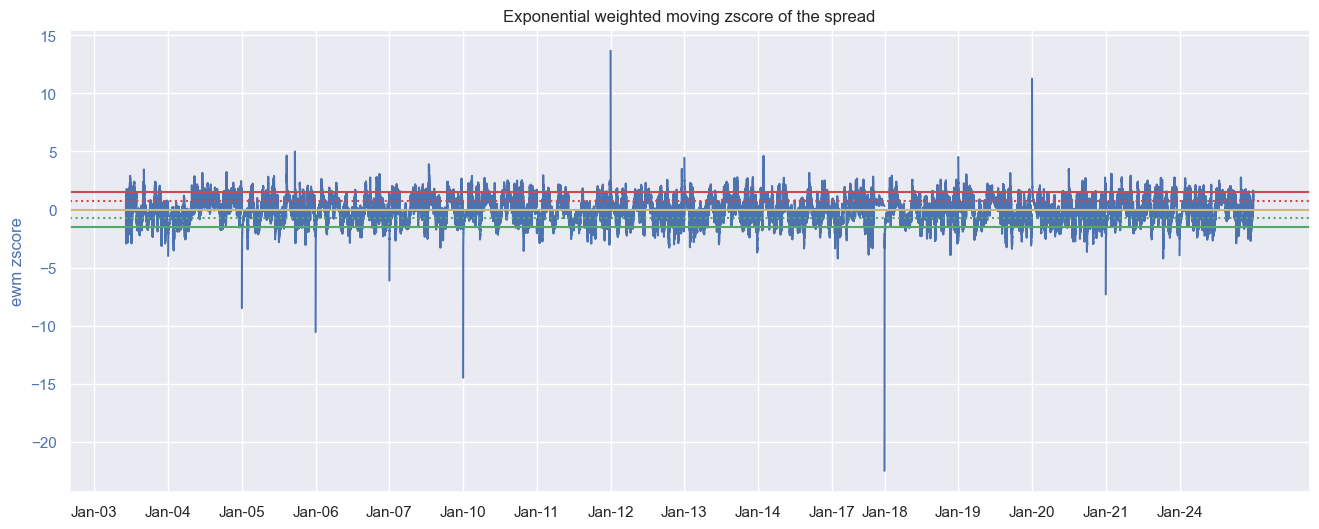

In [95]:
ax = graph_continuous( 
    spread_zscore,
    title="Exponential weighted moving zscore of the spread",
    labels=["ewm zscore"]
)
ax.axhline(0, color="y")
ax.axhline(0.7, color="r", linestyle=":")
ax.axhline(1.5, color="r")
ax.axhline(-0.7, color="g", linestyle=":")
ax.axhline(-1.5, color="g")

In [96]:
# examples of enter and exit thresholds are shown in the graph, but this can be tweeked in the actual backtest

In [97]:
def plot_zscore_spread_period(zscore, spread, freq, span, high_enter=2, high_exit=1, low_enter=-2, low_exit=-1):
    """ Plots a random sample of the zscore and spread on a smaller time frame, that can be set by freq and span"""
    end_of_day = pd.Timestamp("21:00").time()
    span_td = pd.Timedelta(span)
    while ((sample_key := zscore.index.to_series().sample().iloc[0]) + span_td).time() > end_of_day:
        pass
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4), sharex=True, gridspec_kw={'hspace': 0})
    zscore.loc[sample_key:sample_key + span_td].plot(ax=ax1, title=f"{sample_key} to {sample_key+span_td}", ylabel="zscore")
    spread.loc[sample_key:sample_key + span_td].plot(ax=ax2, ylabel="spread", color="orange")
    ax1.axhline(0, color="y")
    ax1.axhline(high_exit, color="r", linestyle=":")
    ax1.axhline(high_enter, color="r")
    ax1.axhline(low_exit, color="g", linestyle=":")
    ax1.axhline(low_enter, color="g")

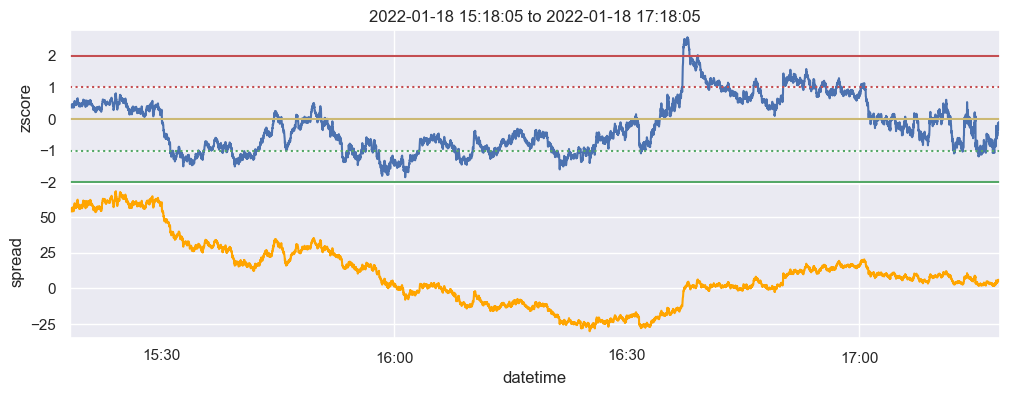

In [98]:
plot_zscore_spread_period(spread_zscore, spread3, freq="15T", span="2H")

### 4.3.1 Evaluating relationship between zscore thresholds, ewm halflife and spread returns

In [99]:
def eval_zscores(spread, halflife, sell_enter, sell_exit, buy_enter, buy_exit, plot=False):
    
    # calculate exponentially weighted mean and std deviation of spread for given halflife
    spread_ewm = spread.ewm(halflife=halflife)
    spread_zscore = (spread - spread_ewm.mean()) / spread_ewm.std()

    # identify sell and buy signals based on zscore thresholds
    sells = spread_zscore > sell_enter
    possible_sell_exits = spread_zscore < sell_exit
    buys = spread_zscore < buy_enter
    possible_buy_exits = spread_zscore > buy_exit

    # track cumulative sum of sells and buys for exit condition evaluation
    sells_so_far = sells.cumsum()
    buys_so_far = buys.cumsum()

    # determine exit points for each buy and sell
    sell_exits = (possible_sell_exits & (sells_so_far>0)).groupby(sells_so_far).cummax()
    sell_exits ^= sell_exits.shift(1) & sell_exits
    buy_exits = (possible_buy_exits & (buys_so_far>0)).groupby(buys_so_far).cummax()
    buy_exits ^= buy_exits.shift(1) & buy_exits
    
    # map sells to their exit points (in datetime)
    sell_enter2exit = sell_exits.index.to_frame(name="exit").copy()
    sell_enter2exit[~sell_exits] = np.NaN
    sell_enter2exit.bfill(inplace=True)
    sell_enter2exit.fillna(spread_zscore.index[-1], inplace=True)
    
    # get value of spread at each sell and exit
    sell_spread = pd.concat([spread[sells].to_frame("enter"), sell_enter2exit[sells].map(lambda x: spread.loc[x])], axis=1)

    # map buys to their exit points (in datetime)
    buy_enter2exit = buy_exits.index.to_frame(name="exit").copy()
    buy_enter2exit[~buy_exits] = np.NaN
    buy_enter2exit.bfill(inplace=True)
    buy_enter2exit.fillna(spread_zscore.index[-1], inplace=True)

    # get value of spread at each buy and exit
    buy_spread = pd.concat([spread[buys].to_frame("enter"), buy_enter2exit[buys].map(lambda x: spread.loc[x])], axis=1)

    # get return of spread between enter and exit points
    sell_diff = sell_spread["exit"] - sell_spread["enter"]
    buy_diff = buy_spread["exit"] - buy_spread["enter"]
    
    # get all bets and append zscore to them
    bets = pd.concat([sell_diff, buy_diff]).sort_index().to_frame(name="spread_diff")
    bets["zscore"] = spread_zscore.loc[bets.index]
    # get pnl spread diff or minus spread diff depending on bet side 
    bets["pnl"] = bets["spread_diff"] * np.where(bets["zscore"] > 0, -1, 1)

    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        # graph zscore and corresponding diff over time in scatter plot
        points = ax1.scatter(bets["zscore"], bets["spread_diff"], c=np.linspace(0.1, 1, len(bets)), s=1, cmap="twilight")
        cbar = fig.colorbar(points)
        cbar.ax.set_yticklabels([str(p.date()) for p in bets[::len(bets)//10].index])
        ax1.set_xlabel("EWM Zscore")
        ax1.set_ylabel("Spread Difference")
        ax1.set_title("Relationship between ZScore and Spread Difference throughout time")
        
        #bin zscores by values and see distribution
        sns.violinplot(data=bets, x=pd.cut(bets["zscore"], [-5, -4, -3, buy_enter, sell_enter, 3, 4, 5]), y="spread_diff", ax=ax2)
        ax2.set_title("Distribution of Spread Difference for sizes of Zscore")
        ax2.set_xlabel("EWM Zscore")
        ax2.set_ylabel("Spread Difference")
    
    return bets

/var/folders/9w/vls_pj350g3b62pyz_4t5hp80000gn/T/ipykernel_92597/45286912.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([str(p.date()) for p in bets[::len(bets)//10].index])


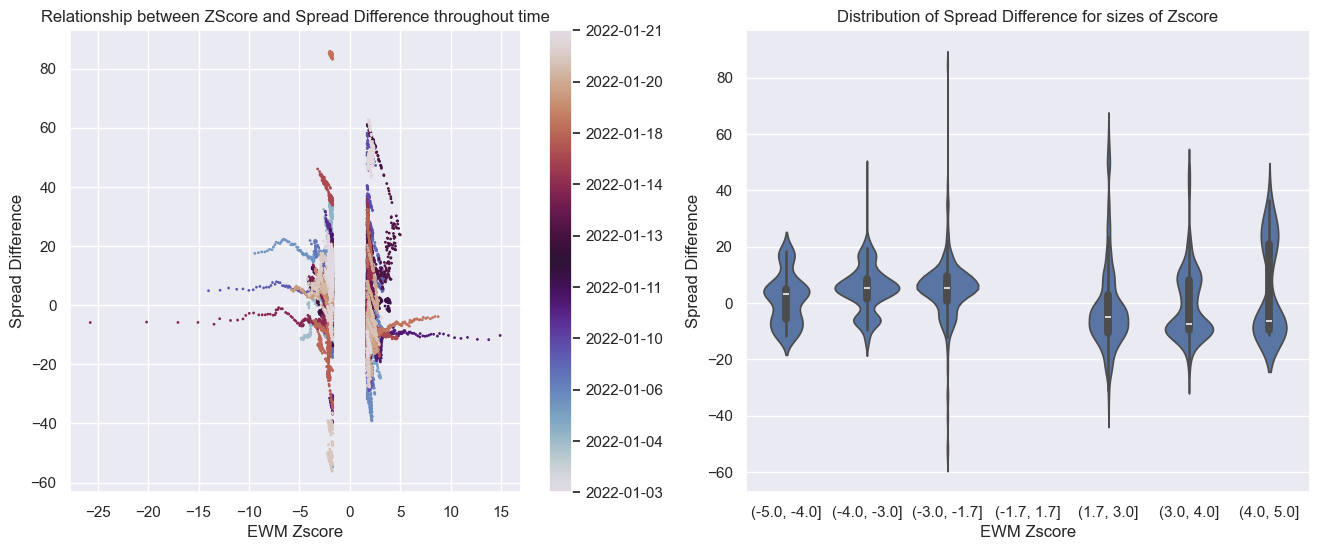

In [100]:
bets = eval_zscores(spread3, 720, 1.7, 0.6, -1.7, -0.6, plot=True)

In [101]:
# by trial and error, I managed to get those values, which give quite good results: 
# - positive zscores give more negative leading returns (as expected by mean reversion)
# - negative zscores give more positive leading returns (as expected by mean reversion)

In [102]:
# sharpe ratio is not very high
bets["pnl"].mean() / bets["pnl"].std()

0.24664201754231033

In [103]:
# a lot of trades are happning
bets.shape[0]

24441

In [104]:
# computing final zscore
spread_ewm = spread3.ewm(halflife=720)
spread_zscore_final = (spread3 - spread_ewm.mean()) / spread_ewm.std()

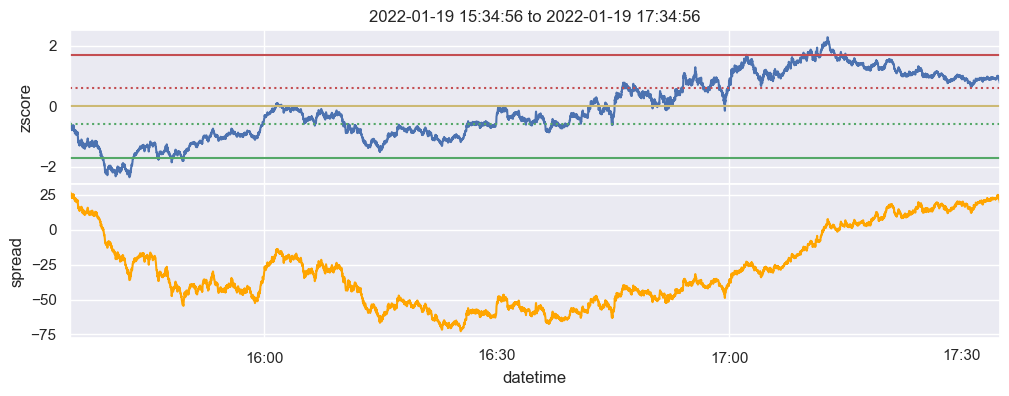

In [105]:
plot_zscore_spread_period(spread_zscore_final, spread3, freq="15T", span="2H", high_enter=1.7, high_exit=0.6, low_enter=-1.7, low_exit=-0.6)

# 5. Backtesting

## 5.0 Backtesting helper classes

In [106]:
# Define enumerations for tickers, sides, and statuses to standardize usage across the trading system.

Ticker = Enum("Ticker", ["ESc1", "NQc1"])
"""
Ticker: Represents the specific futures contracts being traded.
- ESc1: S&P 500 futures contract.
- NQc1: NASDAQ 100 futures contract.
"""

Side = Enum("Side", ["BUY", "SELL"])
"""
Side: Indicates the action of the trade.
- BUY: Indicates a purchase order.
- SELL: Indicates a sell order.
"""

Status = Enum("Status", ["CREATED", "STANDING", "EXECUTED"])
"""
Status: Defines the current state of an order.
- CREATED: Order has been created but not yet processed by the trading engine.
- STANDING: Order has been processed by the trading engine but could not be filled (at least not entirely).
- EXECUTED: Order has been fully executed.
"""

'\nStatus: Defines the current state of an order.\n- CREATED: Order has been created but not yet processed by the trading engine.\n- STANDING: Order has been processed by the trading engine but could not be filled (at least not entirely).\n- EXECUTED: Order has been fully executed.\n'

In [107]:
# Define Order class as a NamedTuple for immutable order attributes with optional price initialization.

class Order(NamedTuple):
    """
    Represents a trading order with defined attributes.

    Attributes:
    - id (int): Unique identifier for the order.
    - trade_id (int): Unique identifier for the trade corresponding to that order (in pair trading, one trade is at least two orders).
    - timestamp (pd.Timestamp): Timestamp when the order was created.
    - ticker (Ticker): Enum specifying the futures contract (e.g., ESc1, NQc1).
    - side (Side): Enum indicating the trade action (BUY or SELL).
    - quantity (int): Number of contracts to be traded.
    - status (Status): Enum indicating the current status of the order (default to CREATED).
    - price (Optional[float]): Execution price of the order. None if the price is not yet determined.

    The default status is set to CREATED, and the price can optionally be set at order creation.
    """
    id: int
    trade_id: int
    timestamp: pd.Timestamp
    ticker: Ticker
    side: Side
    quantity: int
    status: Status = Status.CREATED
    price: Optional[float] = None

In [108]:
class Position:
    """
    Represents a trading position for a specific ticker, managing executed orders and calculating net position size.

    The Position class tracks the state of a trader's position in a particular financial instrument, maintaining
    records of executed buy and sell orders. It supports operations to update the position with new orders, and to
    calculate the net size of the position (the difference between long and short orders).

    Attributes:
        _ticker (Ticker): The ticker (futures contract) this position is for.
        _executed_orders (list[Order]): List of executed orders that have affected this position.
        _open_long (list[Order]): List of open long orders.
        _open_short (list[Order]): List of open short orders.

    Methods:
        _update(new_order: Order): Updates the position with a new order.
        _offset(new_quantity: int, open_opposite: list[Order], mul: int): Offsets a new order against existing opposite orders.
        orders: Property that returns a list of all executed orders.
        size: Property that calculates and returns the net size of the position.

    The position is designed to prevent direct manipulation of its attributes, encapsulating the logic for order
    management and position calculation within its methods.
    """
    def __init__(self, ticker: Ticker):
        self._ticker: Ticker = ticker
        self._executed_orders = []
        self._open_long = []
        self._open_short = []

    def _update(self, new_order: Order):
        # addping new order to the executed ones
        self._executed_orders.append(new_order)
        # copy quantity (by value) to not modify the order in _executed_orders
        new_quantity = new_order.quantity
        if new_order.side == Side.BUY:
            # offset position and get remaining quantity
            remaining_quantity = self._offset(new_quantity, self._open_short, -1)
            # append remaining quantity if its none zero
            if remaining_quantity > 0:
                self._open_long.append(new_order._replace(quantity=remaining_quantity))
        else:
            # offset position and get remaining quantity
            remaining_quantity = self._offset(new_quantity, self._open_long, 1)
            # append remaining quantity if its none zero
            if remaining_quantity > 0:
                self._open_short.append(new_order._replace(quantity=remaining_quantity))
        
        
    def _offset(self, new_quantity, open_opposite, mul):
        # offset position while it's possible
        while open_opposite and new_quantity > 0:
            # get last order and quantity (copy by value)
            last_order = open_opposite.pop()
            last_quantity = last_order.quantity
            # if order in the opposite side is larger than new order, append order with remaining quantity to open list
            if last_quantity > new_quantity:
                last_quantity -= new_quantity
                new_quantity = 0
                open_opposite.append(last_order._replace(quantity=last_quantity))
            # otherwise, simply offset the new order's quantity
            else:
                new_quantity -= last_order.quantity
        return new_quantity

    @property
    def orders(self):
        return self._executed_orders
        
    @property
    def size(self):
        # gives the number of quantities of the position
        if self._open_long:
            return sum([o.quantity for o in self._open_long])
        elif self._open_short:
            return -sum([o.quantity for o in self._open_short])
        else:
            return 0
            
    def __repr__(self):
        return "Position(" + self._ticker.name + ", " + str(self.size) + ")"

In [109]:
class TradingEngine(ABC):
    """
    Abstract base class for a trading engine, managing standing orders and execution logic.

    This class provides a framework for implementing trading strategies and execution mechanisms. It manages
    a queue of standing orders and provides methods for loading market data, calculating net standing quantities,
    and executing trades.

    Attributes:
        standing_orders (deque): A deque to hold standing orders for execution.
    """

    def __init__(self):
        # initialize with an empty deque for holding standing orders
        self.standing_orders = deque([])

    def _load_data(self, data):
        # load market data into the engine
        self.data = data

    @property
    def standing_quantities(self):
        # calculate and return the net standing quantities for each ticker
        standing = {t: 0 for t in Ticker} 
        for orders in self.standing_orders:
            # ensure orders is a list for iteration
            if not isinstance(orders, list):
                orders = [orders]
            # aggregate quantities by ticker, adjusting for buy/sell side
            for o in orders:
                standing[o.ticker] += o.quantity * (1 if o.side == Side.BUY else -1)
        return standing

    @abstractmethod
    def execute(self, tick, cash, orders: List[Order]) -> Tuple[float, List[Order]]:
        """
        Abstract method to be implemented by subclasses for executing trades.

        Parameters:
            tick: The current market tick or time step.
            cash: The current cash balance available for trading.
            orders (List[Order]): A list of orders to be executed.

        Returns:
            Tuple[float, List[Order]]: A tuple containing the updated cash balance and a list of executed orders.
        """
        raise NotImplementedError

In [110]:
class Strategy(ABC):
    """
    Abstract base class for trading strategies.

    Provides a framework for the implementation of trading strategies, including methods for loading data,
    generating unique order IDs, precomputing strategy-specific values, and evaluating the strategy to generate
    orders based on current market conditions.

    Attributes:
        _id (int): Internal counter for generating unique order IDs.
    """

    def __init__(self):
        # initialize the trade and order ID counter
        self._trade_id_generator = count(1)
        self._order_id_generator = count(1)

    def _load_data(self, data):
        # load market data into the strategy for analysis
        self.data = data

    def gen_trade_id(self): 
        # generate a unique trade ID by incrementing the internal counter
        return next(self._trade_id_generator)
        
    def gen_order_id(self):
        # generate a unique order ID by incrementing the internal counter
        return next(self._order_id_generator)

    @abstractmethod
    def _precompute(self):
        """
        Abstract method for precomputing values necessary for the strategy.

        This method should be implemented by subclasses to perform any precomputation or initialization
        needed by the strategy before the backtest is run (improves runtime efficiency)
        """
        raise NotImplementedError

    @abstractmethod
    def evaluate(self, tick, cash, positions: Dict[Ticker, Position], engine: TradingEngine) -> Optional[Dict[Ticker, Order]]:
        """
        Abstract method to evaluate the strategy and generate orders.

        Parameters:
            tick: The current market tick or time step.
            cash: The current cash balance available for trading.
            positions (Dict[Ticker, Position]): The current positions held, indexed by ticker.
            engine (TradingEngine): The trading engine to be used for order execution.

        Returns:
            Optional[Dict[Ticker, Order]]: A dictionary of orders to be executed, indexed by ticker, or None if no action is required.
        """
        raise NotImplementedError

In [111]:
class BacktestEngine:
    """

    This backtesting engine integrates market data, trading strategies, and execution logic to simulate the performance of trading strategies over historical data. 
    It tracks cash balances, positions, orders, and evaluates strategy performance, providing insights into the strategy's potential effectiveness in live trading.

    Attributes:
        _data (DataFrame): Historical market data used for backtesting.
        _ticks (Index): Timestamps extracted from the market data for iteration during the backtest.
        _trading_engine (TradingEngine): The engine responsible for executing orders based on market conditions and strategy signals.
        _strategy (Strategy): The trading strategy to be backtested, encapsulating the logic for generating trade signals.
        _cash (float): Initial cash balance for the backtest.
        _hist_cash (Series): Historical record of cash balances throughout the backtesting period.
        _positions (Dict[Ticker, Position]): Current open positions with Position objects, indexed by ticker.
        _hist_positions (DataFrame): Historical record of position sizes throughout the backtesting period.
        _strategy_orders (dict): Orders generated by the strategy, indexed by ticker.
        _standing_orders (dict): Orders that have been placed but not yet executed or canceled in the trading engine.
        _marked_to_market_value (DataFrame): Historical record of the marked-to-market value of all positions.

    Methods:
        set_data(data): Sets the market data for the backtest.
        set_trading_engine(trading_engine): Sets the trading engine to be used for order execution.
        set_strategy(strategy): Sets the trading strategy to be backtested.
        run(): Executes the backtest over the provided market data.
        _trade(tick): Processes trading signals and executes orders for a single tick.
        _eval_open_positions(tick): Evaluates and updates the marked-to-market value of open positions.
        positions: Property that returns the current positions as a DataFrame.
        strategy_orders: Property that returns all strategy-generated orders as a DataFrame.
        orders: Property that returns all executed orders as a DataFrame.
        standing_orders: Property that returns the current standing orders.
        standing_orders_history: Property that returns the history of standing orders as a DataFrame.
        evaluate(): Evaluates the overall performance of the backtested strategy, generating performance metrics and visualizations.
        
    The engine is designed to be flexible, allowing for the integration of different data sources, trading strategies, and execution mechanisms. It provides a framework for rigorous testing of trading strategies in a simulated market environment.
    """
    def __init__(self, init_cash):
        # initialize all attributes
        self._data = None
        self._ticks = None

        self._trading_engine = None
        self._strategy = None
        
        self._cash = init_cash
        self._hist_cash = None
        
        self._positions = {t: Position(t) for t in Ticker}
        self._hist_positions = None

        self._strategy_orders = {t: [] for t in Ticker} 
        self._standing_orders = None
        self._marked_to_market_value = None
        
        

    def set_data(self, data):
        # update attributes from backtesting data
        self._data = data
        self._ticks = data.unstack("symbol").index
        self._hist_cash = pd.Series(index=self._ticks)
        self._hist_positions = pd.DataFrame(index=self._ticks, columns=[t.name for t in Ticker])
        self._standing_orders = {}
        self._marked_to_market_value = pd.DataFrame(index=self._ticks, columns=[t.name for t in Ticker])
        return self

    def set_trading_engine(self, trading_engine):
        # set trading engine
        if self._data is None:
            raise ValueError("set data with set_data method before setting trading engine")
        self._trading_engine = trading_engine
        # adding data to the engine
        self._trading_engine._load_data(self._data)
        return self

    def set_strategy(self, strategy):
        if self._data is None:
            raise ValueError("set data with set_data method before setting strategy")
        self._strategy = strategy
        # adding data to the strategy and precompute before running
        self._strategy._load_data(self._data)
        self._strategy._precompute()
        return self
        
    def run(self):
        # main loop: iterates over each tick, trades and evaluates
        for tick in tqdm(self._ticks):
            self._trade(tick)
            self._eval_open_positions(tick)
            
    def _trade(self, tick):
        # processes trading signals and executes orders for a single tick
        # getting orders from strategy
        orders = self._strategy.evaluate(tick, self._cash, self._positions, self._trading_engine) or {}

        # if some orders have been given
        if orders:
            # store strategies
            for t, order in orders.items():
                self._strategy_orders[t].append(order)
        # execute strategy orders, or standing orders
        self._cash, executed_orders = self._trading_engine.execute(tick, self._cash, orders)

        # store current cash
        self._hist_cash[tick] = self._cash

        # update positions from executed orders
        for order in executed_orders:
            self._positions[order.ticker]._update(order)
            
        # store standing orders
        self._standing_orders[tick] = self._trading_engine.standing_orders.copy()
            
    def _eval_open_positions(self, tick):
        # evaluates and updates the marked-to-market value of open positions
        for t, pos in self._positions.items():
            self._marked_to_market_value.loc[tick, t.name] = pos.size * self._data.loc[t.name, tick]["mid_price"]
            self._hist_positions.loc[tick][t.name] = pos.size
    
    @property
    def positions(self):
        return pd.DataFrame({t.name: pos.size for t, pos in self._positions.items()}, index=["position"]).copy()

    @property
    def strategy_orders(self):
        return pd.DataFrame(o._asdict() for o in chain.from_iterable([orders for orders in self._strategy_orders.values()])).set_index(["timestamp", "ticker"]).sort_index().copy()
        
    @property
    def orders(self):
        orders_df = pd.DataFrame(o._asdict() for o in chain.from_iterable([p.orders for p in self._positions.values()])).copy()
        if orders_df.empty:
            orders_df = pd.DataFrame(columns=["id", "timestamp", "ticker", "side", "quantity", "price"])
        else:
            orders_df['ticker'] = orders_df['ticker'].apply(lambda x: x.name)
        return orders_df.set_index(["timestamp", "ticker"]).sort_index()

    @property
    def standing_orders(self):
        return self._trading_engine.standing_orders

    @property
    def standing_orders_history(self):
        return (
            pd.concat([pd.DataFrame([o._asdict() for o in orders], index=[key]*len(orders)) for key, orders in self._standing_orders.items()])
            .set_index(["timestamp", "ticker"], append=True)
            .sort_index()
        ).copy()
    
    def evaluate(self, plot=True):
        
        # checking that backtest has been done before evaluating
        if self._hist_cash.isna().all():
            raise ValueError("Please run backtest before evaluating it")
            
        # calculate market_to_market cummulative PNL
        self._cummulative_pnl = self._hist_cash + self._marked_to_market_value.sum(axis=1)
    
        # calculate backtest return
        backtest_return = (self._cummulative_pnl.iloc[-1] - self._cummulative_pnl.iloc[0]) / self._cummulative_pnl.iloc[0]
    
        # calculate the multiplier to get yearly metrics
        num_days = (self._cummulative_pnl.index[-1] - self._cummulative_pnl.index[0]).seconds / (7 * 3600)
        yearly_multiplier = 252 / num_days
    
        
        # calculate yearly return and yearly volatility
        returns = self._cummulative_pnl.pct_change()
        yearly_return = returns.mean() * (7 * 3600) * yearly_multiplier
        yearly_std = returns.std() * np.sqrt((7 * 3600) * yearly_multiplier)
        
        # calculate sharpe ratio (no risk free rate)
        sharpe =  yearly_return / yearly_std
    
        # calculate max_drawdown
        max_drawdown = (self._cummulative_pnl.cummax() - self._cummulative_pnl).max()
    
        # copy orders and to calculate by trade statistics 
        orders = self.orders
        # convert side to multiplier (-1 or 1)
        orders["side_mul"] = np.where(orders["side"]==Side.BUY, 1, -1)
        # get cash flow of each order
        orders["cash_flow"] = -orders["side_mul"] * orders["quantity"] * orders["price"]
    
        # get absolute returns  by trade
        trade_absolute_returns = orders.groupby("trade_id")["cash_flow"].sum()
    
        # calculate slippage from mid price for each trade
        # I decided to set the mid price at the time of the trade signal to be the reference price
        mid_prices = self._data["mid_price"].copy().swaplevel(0,1).sort_index()
        mid_prices.index.names = ["ticker", "timestamp"]
        orders["curr_mid_price"] = mid_prices
        # set mid price from first entering or exiting the trade as the reference  
        orders["reference_price"] = orders.groupby(["ticker", "trade_id", "side_mul"])["curr_mid_price"].transform("first")
        orders["slippage"] = (orders["reference_price"] - orders["price"]) * orders["side_mul"] * orders["quantity"]
        
        slippage_by_trade = orders.groupby("trade_id")["slippage"].sum() 
        
        if plot:
            ax = graph_continuous( 
                self._cummulative_pnl,
                title="PNL with marked-to-market positions",
                labels=["Dollar MTM PNL"]
                
            )
        return backtest_return, yearly_return, yearly_std, sharpe, max_drawdown, trade_absolute_returns, slippage_by_trade


## 5.1 Implementation of my Strategy

In [112]:
class EWMZscoreSymmetric(Strategy):
    """
    Implements a symmetric mean reversion strategy based on the z-score of the spread between two assets,
    adjusted for exponential weighted moving average (EWMA). It enters and exits trades based on specified z-score thresholds.

    This strategy calculates the spread between two assets using an iterative OLS regression, in order to avoid leakage, then applies
    an EWMA to the spread to calculate z-scores. Trades are initiated when the z-score crosses predefined entry thresholds
    and are exited when the z-score reverts back within an exit threshold. Position sizing varies based on the z-score
    magnitude, allowing for dynamic allocation based on signal strength.
    """
    def __init__(self, z_enter, z_max, z_exit, min_sizing, max_sizing, ewm_halflife, ewm_burnout, ols_step="15T", ols_window="3H"):
        # initialize strategy 
        super().__init__()
        
        # zscore thresholds for trade entry and exit
        self._z_enter = z_enter
        self._z_max = z_max
        self._z_exit = z_exit
        
        # position sizing parameters
        self._max_sizing = max_sizing
        self._sizing_slope = (max_sizing - min_sizing) / (z_max - z_enter)
        self._sizing_intercept = min_sizing

        # ewm parameters for zscore
        self._ewm_halflife = ewm_halflife
        self._ewm_burnout = ewm_burnout
        
        # OLS regression parameters for hedge ratio calculation
        self._ols_step = ols_step
        self._ols_window = ols_window

        self._current_spread_side = 0
        

    def _precompute(self):
        # precomputes necessary data for trading decisions
        # calculate spread and zscores using ewma.
        self.mid_prices = self.data["mid_price"].unstack("symbol")
        self.hedge_ratio, self.fitted_spread = no_leakage_ols_spread(self.mid_prices, step=self._ols_step, window=self._ols_window)
        spread_ewm = self.fitted_spread.ewm(halflife=self._ewm_halflife)
        self.zscore = ((self.fitted_spread - spread_ewm.mean()) / spread_ewm.std()).transform(lambda x: x.mask(x.index.isin(x.index[:self._ewm_burnout]), 0))
        
        # calculate entry and exit signals based on z-scores
        self._enters = self.zscore.apply(self._enter_eval)
        self._buy_exits = self.zscore > -self._z_exit
        self._sell_exits = self.zscore < self._z_exit

        self._spread_sides = pd.Series(index=self.mid_prices.index)


    def _enter_eval(self, zscore):
        # evaluates if a new entry trade should be made based on zscore
        abs_z = abs(zscore)
        sign = np.sign(zscore)
        
        # determine position sizing based on zscore
        if abs_z < self._z_enter:
            return 0
        if abs_z >= self._z_max:
            return -sign * self._max_sizing
        return -sign * (self._sizing_slope * (abs_z - self._z_enter) + self._sizing_intercept)
        
    def _exit_eval(self, zscore):
        # determines if positions should be exited based on zscore
        return (-self._z_exit <= zscore) & (zscore <= self._z_exit)


    def evaluate(self, tick, cash, positions, engine):
        # main method to evaluate and execute trades
        
        # calculate current quantities 
        standing_qtys = engine.standing_quantities
        positions_qtys = {t:positions[t].size for t in Ticker}
        self.curr_qtys = {t:standing_qtys[t] + positions_qtys[t] for t in Ticker}

        
        # execute entry or exit trades based on current positions and signals
        # if enter signal and not invested
        if (enter_prop := self._enters[tick]) != 0 and (self._current_spread_side == 0):
            
            self._current_trade_id = self.gen_trade_id()
            self._current_spread_side = 1 if enter_prop > 0 else -1
            self._spread_sides.loc[tick] = self._current_spread_side
            
            # calculate quantity of NQc1
            NQc1_qty = cash * abs(enter_prop) / (self.mid_prices.loc[tick, "NQc1"] + self.hedge_ratio[tick] * self.mid_prices.loc[tick, "ESc1"])
            # calculate quantity of ESc1
            ESc1_qty = self.hedge_ratio[tick] * NQc1_qty
            
            if enter_prop > 0:
                return self._send_enter_orders(tick, int(np.floor(NQc1_qty)), -int(np.ceil(ESc1_qty)))
            else:
                return self._send_enter_orders(tick, -int(np.ceil(NQc1_qty)), int(np.floor(ESc1_qty)))
        
        elif (enter_prop := self._enters[tick]) != 0 and (np.sign(enter_prop) != self._current_spread_side):
            self._current_spread_side = 0
            self._spread_sides.loc[tick] = self._current_spread_side
            # send orders to close all positions
            return self._send_close_orders(tick)

        elif (self._buy_exits[tick] and self._current_spread_side == 1):
            self._current_spread_side = 0
            self._spread_sides.loc[tick] = self._current_spread_side
            # send orders to close all positions
            return self._send_close_orders(tick)
            
        elif (self._sell_exits[tick] and self._current_spread_side == -1):
            self._current_spread_side = 0
            self._spread_sides.loc[tick] = self._current_spread_side
            # send orders to close all positions
            return self._send_close_orders(tick)
        
            
            

    def _send_enter_orders(self, tick, NQc1_qty, ESc1_qty):
        # generates orders for entering positions
        return {
            t: Order(self.gen_order_id(), self._current_trade_id, tick, t, Side.BUY if qty > 0 else Side.SELL, abs(qty))
            for t, qty in zip(Ticker, [ESc1_qty, NQc1_qty]) if qty != 0
        }

    def _send_close_orders(self, tick):
        # generates orders to close existing positions
        return {
                t: Order(self.gen_order_id(), self._current_trade_id, tick, t, Side.BUY if self.curr_qtys[t] < 0 else Side.SELL, abs(self.curr_qtys[t]))
                for t in Ticker if self.curr_qtys[t] != 0
            }

## 5.2 Backtest No1 : No T Cost and Infinite Liquidity

In [113]:
class MidPriceInfLiquidity(TradingEngine):
    """
    An unrealistic trading engine that executes at mid price and there is unlimited liquidity
    """
        
    def execute(self, tick, cash, new_orders):
        """
        Executes standing and new orders for a given tick.
        
        Parameters:
            tick (datetime): The current time tick.
            cash (float): Current available cash.
            new_orders (dict): New orders to be executed.
        
        Returns:
            tuple: Updated cash and list of executed orders.
        """
        
        self.tick = tick
        self.current_cash = cash
        # retrieve current prices and depths for the tick
        self.current_prices = self.data.xs(tick, level="datetime")["mid_price"]
        
        executed_orders = []

        # process new orders
        for o in new_orders.values():
            executed_orders.append(self.trade(o))

        return (self.current_cash, executed_orders)

    def trade(self, order):
        """
        Executes a single order based on current market conditions.

        Parameters:
            order (Order): The order to be executed.

        Returns:
            Order: Updated order with execution details, or None if not executed.
        """
        # check that no order is negative
        if order.quantity <= 0:
            raise ValueError(f"at {self.tick}: {order} has negative quantity of {order.quantity}")

        # get mid price
        trade_price = self.current_prices.loc[order.ticker.name]

        cash_change = -1 if order.side == Side.BUY else 1
        
        self.current_cash += cash_change * (trade_price * order.quantity)
        
        # return order
        return order._replace(timestamp=self.tick, status=Status.EXECUTED, quantity=order.quantity, price=trade_price)

### Backtest on train data

In [114]:
backtest1_train = (
    BacktestEngine(init_cash=10_000_000)
    .set_data(train_df)
    .set_trading_engine(MidPriceInfLiquidity())
    .set_strategy(EWMZscoreSymmetric(z_enter=1.8, z_max=4, z_exit=0.6, min_sizing=0.3, max_sizing=0.8, ewm_halflife=720, ewm_burnout=3600*4))
)

0it [00:00, ?it/s]

In [115]:
backtest1_train.run()

  0%|          | 0/396000 [00:00<?, ?it/s]

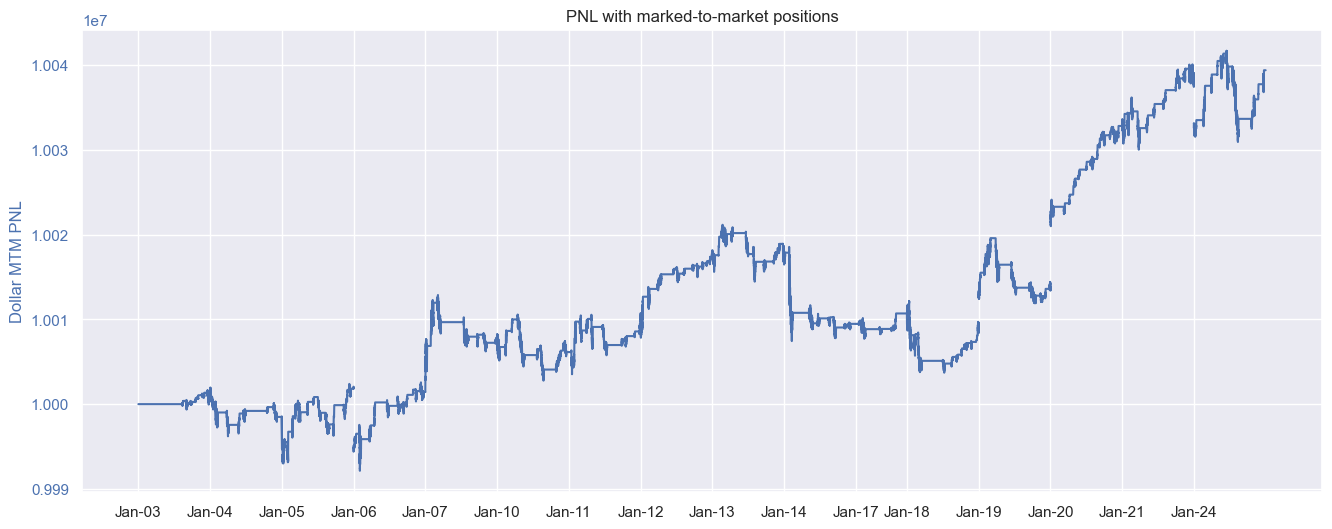

In [116]:
b1_train_res = backtest1_train.evaluate()

### Backtest on test data

In [117]:
backtest1_test = (
    BacktestEngine(init_cash=10_000_000)
    .set_data(test_df)
    .set_trading_engine(MidPriceInfLiquidity())
    .set_strategy(EWMZscoreSymmetric(z_enter=1.8, z_max=4, z_exit=0.6, min_sizing=0.3, max_sizing=0.8, ewm_halflife=720, ewm_burnout=3600*4))
)

0it [00:00, ?it/s]

In [118]:
backtest1_test.run()

  0%|          | 0/126000 [00:00<?, ?it/s]

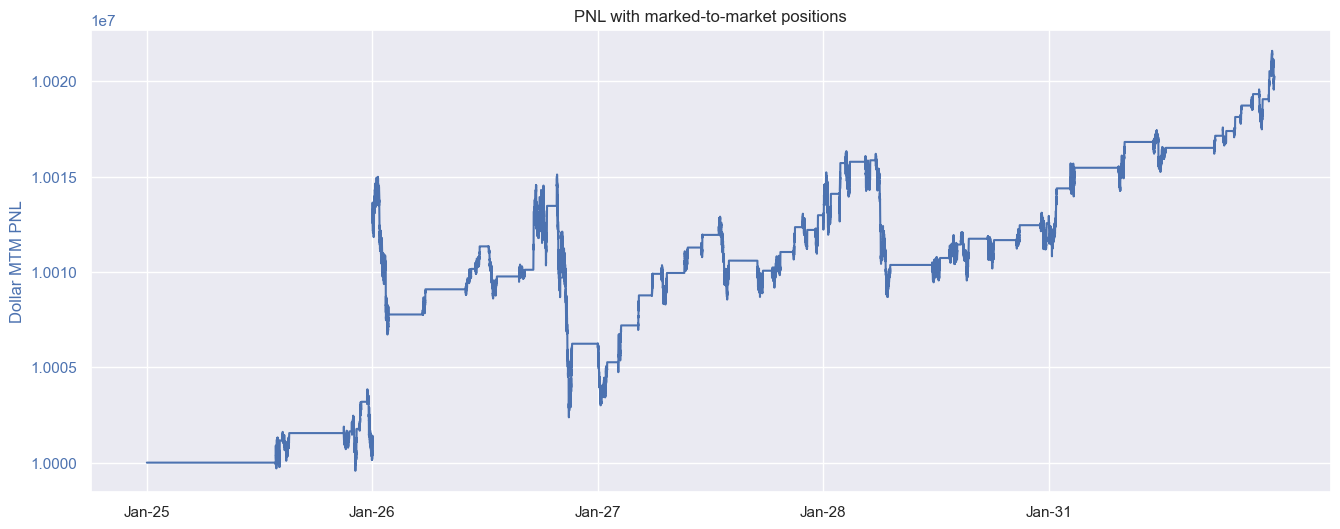

In [119]:
b1_test_res = backtest1_test.evaluate()

## 5.3 Backtest No2 : Bid Ask + T cost + limited liquidity

In [120]:
class BidAskConstTCost(TradingEngine):
    """
    A trading engine that executes orders based on bid and ask prices with constant transaction costs.
    It processes standing orders first, then new orders, while considering bidask spread, transaction costs 
    and liquidity, and updates cash and executed orders accordingly.
    """
    def __init__(self, tcost):
        # initialize engine 
        super().__init__()
        # T cost in dollars
        self._tcost = tcost
        
    def execute(self, tick, cash, new_orders):
        """
        Executes standing and new orders for a given tick.
        
        Parameters:
            tick (datetime): The current time tick.
            cash (float): Current available cash.
            new_orders (dict): New orders to be executed.
        
        Returns:
            tuple: Updated cash and list of executed orders.
        """
        
        self.tick = tick
        self.current_cash = cash
        # retrieve current prices and depths for the tick
        self.current_prices = self.data.xs(tick, level="datetime")[["bid_price", "ask_price"]].copy()
        self.current_depths = self.data.xs(tick, level="datetime")[["bid_size", "ask_size"]].copy()
        
        executed_orders = []

        # process standing orders
        while self.standing_orders:
            o = self.standing_orders.pop()
            if exec_order := self.trade(o):
                executed_orders.append(exec_order)
            else:
                break  # exit if no trade is executed

        # process new orders
        for o in new_orders.values():
            if exec_order := self.trade(o):
                executed_orders.append(exec_order)

        return (self.current_cash, executed_orders)

    def trade(self, order):
        """
        Executes a single order based on current market conditions.

        Parameters:
            order (Order): The order to be executed.

        Returns:
            Order: Updated order with execution details, or None if not executed.
        """
        # check that no order is negative
        if order.quantity <= 0:
            raise ValueError(f"at {self.tick}: {order} has negative quantity of {order.quantity}")

        # determine trade direction and corresponding market depth
        if order.side == Side.BUY:
            corresponding_price = "ask_price"
            corresponding_size = "ask_size"
            cash_change = -1  # cash outflow for buys
        else:
            corresponding_price = "bid_price"
            corresponding_size = "bid_size"
            cash_change = 1  # cash inflow for sells

        trade_price = self.current_prices.loc[order.ticker.name, corresponding_price]

        # handle case where there is no depth for the order
        if self.current_depths.loc[order.ticker.name, corresponding_size] == 0:
            self.standing_orders.append(order)
            return None

        # execute order partially or fully based on available depth
        elif order.quantity > self.current_depths.loc[order.ticker.name, corresponding_size]:
            max_quantity = self.current_depths.loc[order.ticker.name, corresponding_size]
            self.current_cash += cash_change * ((trade_price - self._tcost) * max_quantity)
            self.current_depths.loc[order.ticker.name, corresponding_size] = 0
            self.standing_orders.append(order._replace(timestamp=self.tick, status=Status.STANDING, quantity=order.quantity - max_quantity))
            return order._replace(timestamp=self.tick, status=Status.EXECUTED, quantity=max_quantity, price=trade_price)
        else:
            self.current_cash += cash_change * ((trade_price - self._tcost) * order.quantity)
            self.current_depths.loc[order.ticker.name, corresponding_size] -= order.quantity
            return order._replace(timestamp=self.tick, status=Status.EXECUTED, quantity=order.quantity, price=trade_price)

### Backtest on train data

In [121]:
backtest2_train = (
    BacktestEngine(init_cash=10_000_000)
    .set_data(train_df)
    .set_trading_engine(BidAskConstTCost(tcost=0.1))
    .set_strategy(EWMZscoreSymmetric(z_enter=1.8, z_max=4, z_exit=0.6, min_sizing=0.3, max_sizing=0.8, ewm_halflife=720, ewm_burnout=3600*4))
)

0it [00:00, ?it/s]

In [122]:
backtest2_train.run()

  0%|          | 0/396000 [00:00<?, ?it/s]

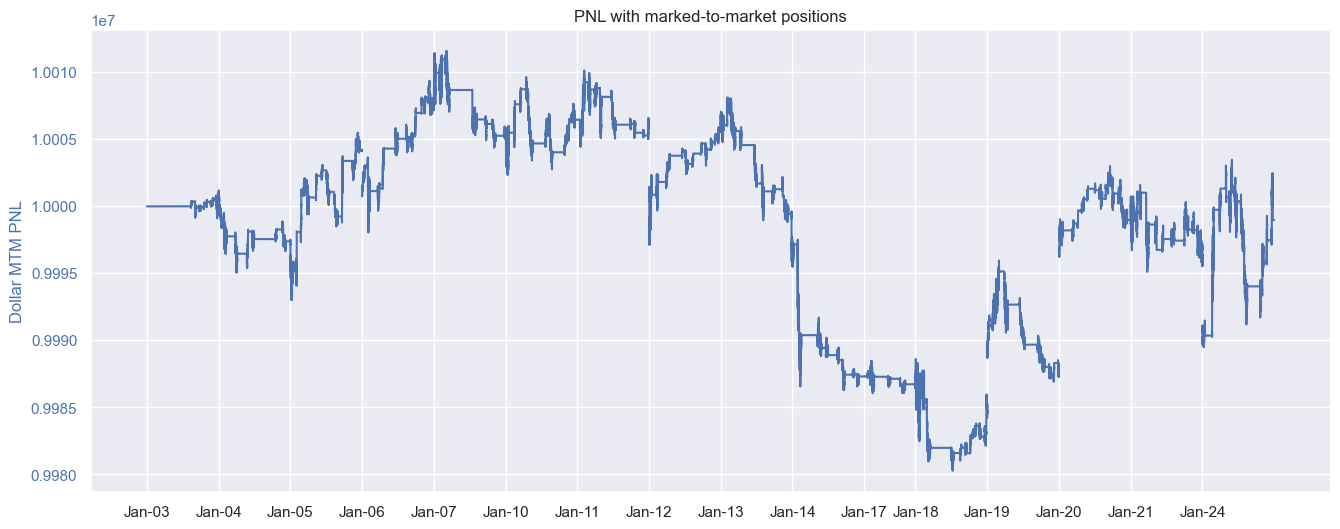

In [123]:
b2_train_res = backtest2_train.evaluate()

### Backtest on test data

In [124]:
backtest2_test = (
    BacktestEngine(init_cash=10_000_000)
    .set_data(test_df)
    .set_trading_engine(BidAskConstTCost(tcost=0.1))
    .set_strategy(EWMZscoreSymmetric(z_enter=1.8, z_max=4, z_exit=0.6, min_sizing=0.3, max_sizing=0.8, ewm_halflife=720, ewm_burnout=3600*4))
)

0it [00:00, ?it/s]

In [125]:
backtest2_test.run()

  0%|          | 0/126000 [00:00<?, ?it/s]

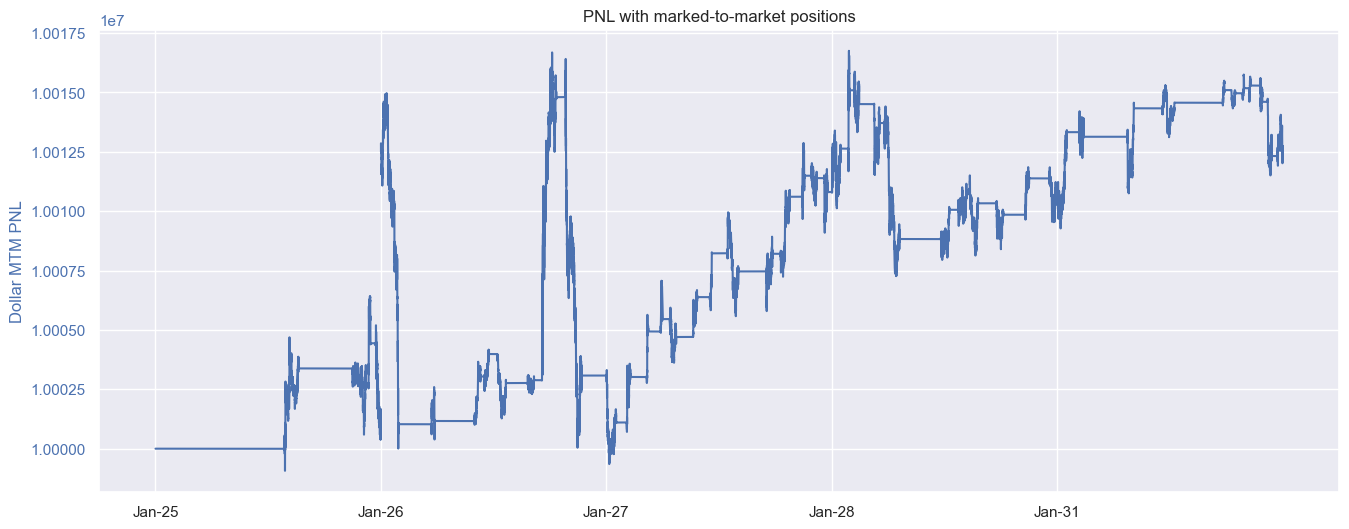

In [126]:
b2_test_res = backtest2_test.evaluate()